In [2]:
from initialize import *
%load_ext autoreload
%autoreload 2

/Users/christopherackerman/repos/spar_self_recognition/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Paired Presentation

In [ ]:
### Inspect texts where model gets paired judgments right/wrong/ambiguous

def inspect_texts(tokens, dataset, model_name, compmodel, task):
    if task == TaskType.HumanVModel:
        choices = load_from_json(f'choice_results_humanVmodel/{dataset}_{model_name}_HvM_Mis{compmodel}_untuned.json')
        self_summaries = load_from_json(f'summaries/{dataset}_train_{model_name}_responses.json')
        other_summaries = load_from_json(f'summaries/{dataset}_train_{compmodel}_responses.json')
    elif task == TaskType.SelfVOther:
        choices = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise_untuned.json')
        self_summaries = load_from_json(f'summaries/{dataset}_train_{model_name}_responses.json')
        other_summaries = load_from_json(f'summaries/{dataset}_train_{compmodel}_responses.json')
    elif task == TaskType.SelfVOther_Continuation:
        choices = load_from_json(f'completions/{dataset}_{model_name}_SvO_continuation_untuned.json')
        completions = load_from_json(f"completions/completions_{model_name}__train.json")
        self_summaries = {d['id']: d['text'] for d in completions}
        completions = load_from_json(f"completions/completions_{compmodel}__train.json")
        other_summaries = {d['id']: d['text'] for d in completions}
    else:
        print("Invalid task type")
        return
    cordicts, incordicts, ambigdicts = [], [], []
    for choice in choices:
        if choice['model'] != compmodel: continue
        dict = {}
        dict['key'] = choice['key']
        dict['self_summary'] = self_summaries[choice['key']]
        dict['other_summary'] = other_summaries[choice['key']]
        if choice['forward_detection'] == tokens[0] and choice['backward_detection'] == tokens[1]: cordicts.append(dict)
        elif choice['forward_detection'] == tokens[1] and choice['backward_detection'] == tokens[0]: incordicts.append(dict)
        elif choice['forward_detection'] == choice['backward_detection']: ambigdicts.append(dict)
    save_to_json(cordicts, f'./outputs/{dataset}_{model_name}_V_{compmodel}_incorrect.json')
    save_to_json(incordicts, f'./outputs/{dataset}_{model_name}_V_{compmodel}_correct.json')
    save_to_json(ambigdicts, f'./outputs/{dataset}_{model_name}_V_{compmodel}_ambig.json')

tokens = ['1', '2']
dataset = "cnn"
model_name = "llama3_8bbase"
compmodel = "human"
task = TaskType.HumanVModel
inspect_texts(tokens, dataset, model_name, compmodel, task)


In [175]:
### Compute accuracy of model choices for pairwise task

from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 

def plot_table_as_bar_chart(ax, table, headers, N, task, dataset, colors = None):
    default_colors = colors if colors else plt.rcParams['axes.prop_cycle'].by_key()['color']
    data = {}
    for row in table:
        data[row[0]] = {h: row[i+1] for i, h in enumerate(headers[1:])}

    colors = {h: default_colors[i] for i, h in enumerate(headers[1:])}
    
    models = [row[0] for row in table]
    x = np.arange(len(models))
    width = 0.45 

    # Add a horizontal dashed line at 50%
    ax.axhline(y=50, color='black', linestyle='--', alpha=0.7)

    for i, category in enumerate(headers[1:]):
        values = [float(data[model][category].replace("%",""))/100 for model in models]
        # Calculate 95% CI
        if category == headers[-1]: ci = [1.96 * np.sqrt((v * (1-v)) / (N*2)) for v in values]
        else: ci = [1.96 * np.sqrt((v * (1-v)) / N) for v in values]
        
        # Convert values to percentages
        values_percent = [v * 100 for v in values]
        ci_percent = [c * 100 for c in ci]
        
        bars = ax.bar(x + i*width, values_percent, width, label=category, yerr=ci_percent, capsize=5, color=colors[category])
        
        # Add percentage labels inside the bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{height:.1f}%', ha='center', va='center', fontsize=6)

    ax.set_ylabel('Percentage')
    ax.set_xlabel(headers[0])
    ax.set_title(f"Task = {task.name};  Dataset = {dataset.upper()}", fontsize=9)
    ax.set_xticks(x + width/2) if len(headers) > 2 else ax.set_xticks(x)
    ax.set_xticklabels([model.upper() for model in models], rotation=0, ha='center', fontsize=6)
    ax.legend(fontsize=6)

    # Adjust y-axis to show percentages
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

def avg(l):
    return sum(l) / len(l)
def get_acc_table(results, corvals, models=[]):
    if models == []: models = sorted(set([result['model'] for result in results]), key=lambda x: (x != 'human', x))#models = sorted(set([result['model'] for result in results]))
    task = 'detection' 
    table = [[model.replace("_filteredlen",""), 
                            avg([result[f'forward_{task}'] == corvals[0] and result[f'backward_{task}'] == corvals[1] for result in results if result['model']==model]),
                            avg([result[f'forward_{task}'] == corvals[1] and result[f'backward_{task}'] == corvals[0] for result in results if result['model']==model]),
                            avg([result[f'forward_{task}'] == result[f'backward_{task}'] for result in results if result['model']==model]),
                            avg([result[f'forward_{task}_logprob'][corvals[0]] + result[f'backward_{task}_logprob'][corvals[1]] > 
                                 result[f'forward_{task}_logprob'][corvals[1]] + result[f'backward_{task}_logprob'][corvals[0]] for result in results if result['model']==model]) if isinstance(results[0][f'forward_{task}_logprob'], dict) else 0,
                            avg([int(result[f'forward_{task}'] == corvals[0]) + int(result[f'backward_{task}'] == corvals[1]) for result in results if result['model']==model])/2,
    ] for model in models]

    #table = [row + [row[2] / (row[2] + row[3]) if any(i != 0 for i in [row[2], row[3]]) else 0] for row in table]

    table = [row[0:1] + [f"{round(i*100, 1)}%" for i in row[1:]] for row in table]
    return table
    print(tabulate(table, headers = ['Comparison Model', 'Correct', 'Incorrect', 'Ambiguous', 'LP Avg', 'Correct Full']))#['Comparison Model', 'Ambiguous', 'Correct', 'Incorrect', 'LP Avg', 'Zapped']
    ###print(tabulate(table, headers = ['Comparison Model', 'Correct', 'Incorrect', 'Ambiguous', 'Correct Full']))

#corvals = ['A','B']
#results = load_from_json(f'completions/sad_llama3_8bchat_SvO_continuation_paper_untuned.json')
#print_ambig_table(results, corvals)

task = TaskType.SelfVOther
model_name = "llama3_8bchat"
datasets = ["cnn", "xsum", "dolly", "sad"]
cmp_model_names = ["llama3_8bchat"] if task == TaskType.HumanVModel else []
alias = ""
length_norm_type = "trimmed"#"none"#"filtered" #
test = "reg_table"#"pplx_table"#"len_table" #"acc_table" #"acc_table" #

corvals = ['2','1'] if "HumanVModel" in task.name else ['1','2']

print(f"Model = {model_name}, length_norm_type = {length_norm_type}, task = {task.name}")
for dataset in datasets:
    paradigm = "Completions" if dataset == "sad" else "Summaries"
    print(('' if test == 'reg_table' else '\n') + f"Dataset = {dataset.upper()}, Paradigm = Pairwise {paradigm}")
    if dataset == "sad":
        if length_norm_type == "none": suffix = "_longer_untrimmed"
        elif length_norm_type == "filtered": suffix = "_full"
        else: suffix = "_longer"
        ddir = "completions_longer" if "longer" in suffix else "completions_full" if "full" in suffix else "completions"
        data = load_from_json(f'{ddir}/{dataset}_{model_name}_{task.value}_Continuation{suffix}_untuned.json')
    else:
        if length_norm_type == "trimmed": suffix = "_trim" if model_name == "sonnet" else "_trimmed" 
        elif length_norm_type == "filtered": suffix = "_filteredlen"
        else: suffix = "_untrimmed" #""
        if task == TaskType.HumanVModel:
            if suffix == "_filteredlen": suffix = suffix+suffix
            if suffix == "_untrimmed": suffix = ""
            data = []
            for compmodel in cmp_model_names:
                fname = f'choice_results_humanVmodel/{dataset}_{model_name}_HvM_Mis{compmodel}{suffix}_untuned.json'
                if not os.path.exists(fname): continue
                data.extend(load_from_json(fname))
        elif task == TaskType.SelfVOther:
            try:
                data = load_from_json(f'choice_results/{dataset}_{model_name}_SvO{suffix}_untuned.json')
            except:
                if not os.path.exists(f'choice_results/{dataset}_{model_name}_pairwise_untuned.json'): continue
                data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise_untuned.json')

    if test == "acc_table":
        table = np.array(get_acc_table(data, corvals))
        ###print(tabulate(table[:,[0,-2,-1]], headers = ['Comparison Model', 'LP Avg', 'Correct Full']))
        fig, axs = plt.subplots(1, 1, figsize=(max(2,len(table)) * 1.1, 3))
        if model_name == "sonnet":
            plot_table_as_bar_chart(axs, [[row[0], row[-1]] for row in table], ['Comparison Model', 'Correct Full'], len(data), task, dataset, colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][1]])
        else:
            plot_table_as_bar_chart(axs, [[row[0], row[-2], row[-1]] for row in table], ['Comparison Model', 'Correct Prob Avg', 'Correct Full'], len(data), task, dataset)#, colors = ["blue", "purple"])
        plt.tight_layout()
        plt.savefig(f'./figs/{dataset}.png', dpi=300, bbox_inches='tight')
        plt.show()
    elif test == "pplx_table":
        results = calculate_perplexity_metrics(data, corvals=corvals)
        print(format_perplexity_metrics_table(results, task=task))
    elif test == "len_table":
        if dataset == "sad": responses, _ = load_data_sad(ddir = ddir)
        else: responses, _, _ = load_data(dataset)
        results = calculate_length_metrics(data, responses, "human" if "HvM" in task.value else model_name, corvals=corvals, trim = (length_norm_type == "trimmed"))
        print(format_length_metrics_table(results, task=task))
    elif test == "reg_table":
        if dataset == "sad": responses, _ = load_data_sad(ddir = ddir)
        else: responses, _, _ = load_data(dataset)
        results = calculate_impact_full(data, responses, model_name, corvals=corvals, separate=True, trim = (length_norm_type == "trimmed"), type = "logistic")    
        sdf, df = format_results_full(results)#display(sdf)
        print(df)
    else:
        if dataset == "sad": responses, _ = load_data_sad(ddir = ddir)
        else: responses, _, _ = load_data(dataset)
        visualize_choice_data(data, responses, model_name, comp_model="human", corvals=corvals)


Model = llama3_8bchat, length_norm_type = trimmed, task = SelfVOther
Dataset = CNN, Paradigm = Pairwise Summaries
                                            Length  \
human           -0.07, p=0.1506, Acc=0.64, OR=0.93   
claude           0.15, p=0.0009, Acc=0.53, OR=1.17   
gpt35            0.13, p=0.0038, Acc=0.55, OR=1.14   
gpt4            -0.01, p=0.7462, Acc=0.51, OR=0.99   
llama            0.05, p=0.2471, Acc=0.53, OR=1.05   
llama2_13bchat   0.08, p=0.0843, Acc=0.54, OR=1.08   
llama3_8bbase    0.06, p=0.2326, Acc=0.63, OR=1.06   
sonnet           0.07, p=0.1129, Acc=0.58, OR=1.07   

                                             Pplx  \
human           0.06, p=0.2610, Acc=0.64, OR=1.06   
claude          0.36, p=0.0000, Acc=0.56, OR=1.43   
gpt35           0.17, p=0.0002, Acc=0.55, OR=1.19   
gpt4            0.11, p=0.0189, Acc=0.53, OR=1.12   
llama           0.18, p=0.0002, Acc=0.54, OR=1.19   
llama2_13bchat  0.18, p=0.0003, Acc=0.54, OR=1.19   
llama3_8bbase   0.14, p=0.00

In [142]:
from pdflatex import PDFLaTeX

pdfl = PDFLaTeX.from_texfile('figs/t1.tex')
pdf, log, completed_process = pdfl.create_pdf(keep_pdf_file=True, keep_log_file=True)

[autoreload of attr._make failed: Traceback (most recent call last):
  File "/Users/christopherackerman/repos/spar_self_recognition/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/christopherackerman/repos/spar_self_recognition/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/christopherackerman/repos/spar_self_recognition/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/christopherackerman/repos/spar_self_recognition/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/Users/christopherackerman/repos/spar_self_recognition/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    u

FileNotFoundError: [Errno 2] No such file or directory: 'pdflatex'

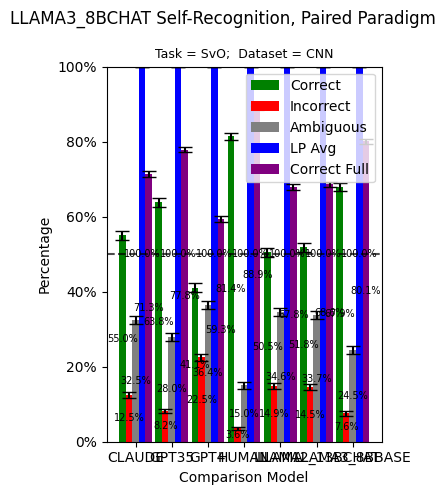

In [89]:
### Plot results

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import numpy as np

def avg(l):
    return sum(l) / len(l)

def create_bar_chart(ax, task, model_name, dataset, corvals, models = [], suffix = "_untuned"):
    if task == TaskType.HumanVModel:
        results = []
        for compmodel in models:
            results.extend(load_from_json(f'choice_results_humanVmodel/{dataset}_{model_name}_HvM_Mis{compmodel}{suffix}.json'))
    elif task == TaskType.SelfVOther:
        results = load_from_json(f'choice_results/{dataset}_{model_name}_SvO{suffix}.json')
    elif task == TaskType.SelfVOther_Continuation or task == TaskType.HumanVModel_Continuation:
        if "longer" in suffix:
            results = load_from_json(f'completions_longer/{dataset}_{model_name}_{task.value}{suffix}.json')
        elif "full" in suffix:
            results = load_from_json(f'completions_full/{dataset}_{model_name}_{task.value}{suffix}.json')
        else: print("Invalid suffix")
    else:
        print("Invalid task type")
        return
    if models == []: models = list(set([result['model'] for result in results]))
    models = sorted(models)
    subtask = 'detection' 
    N = len(results)
    table = [[model, 
                            avg([result[f'forward_{subtask}'] == result[f'backward_{subtask}'] for result in results if result['model']==model]),
                            avg([result[f'forward_{subtask}'] == corvals[0] and result[f'backward_{subtask}'] == corvals[1] for result in results if result['model']==model]),
                            avg([result[f'forward_{subtask}'] == corvals[1] and result[f'backward_{subtask}'] == corvals[0] for result in results if result['model']==model]),
                            1,#avg([result[f'forward_{subtask}_logprob'][corvals[0]] + result[f'backward_{subtask}_logprob'][corvals[1]] > result[f'forward_{subtask}_logprob'][corvals[1]] + result[f'backward_{subtask}_logprob'][corvals[0]] for result in results if result['model']==model]),
                            avg([int(result[f'forward_{subtask}'] == corvals[0]) + int(result[f'backward_{subtask}'] == corvals[1]) for result in results if result['model']==model])/2,
    ] for model in models]
    table = [row[0:1] + [round(i, 3) for i in row[1:]] for row in table]
    data = {}
    for row in table:
        data[row[0]] = {'Ambiguous': row[1], 'Correct': row[2], 'Incorrect': row[3], 'LP Avg': row[4], 'Correct Full': row[5]}

    colors = {'Ambiguous': 'gray', 'Correct': 'green', 'Incorrect': 'red', 'LP Avg': 'blue', 'Correct Full': 'purple'}
    
    x = np.arange(len(models))
    width = 0.18#25

    # Add a horizontal dashed line at 50%
    ax.axhline(y=50, color='black', linestyle='--', alpha=0.7)

    for i, category in enumerate(['Correct', 'Incorrect', 'Ambiguous', 'LP Avg', 'Correct Full']):
        values = [data[model][category] for model in models]
        # Calculate 95% CI
        #ci = [1.96 * np.sqrt((v * (1-v)) / N) for j, v in enumerate(values) if j != len(values) - 1]
        #ci.append(1.96 * np.sqrt((values[-1] * (1-values[-1])) / (N*2000)))
        if category == 'Correct Full': ci = [1.96 * np.sqrt((v * (1-v)) / (N*2)) for v in values]
        else: ci = [1.96 * np.sqrt((v * (1-v)) / N) for v in values]
        
        # Convert values to percentages
        values_percent = [v * 100 for v in values]
        ci_percent = [c * 100 for c in ci]
        
        bars = ax.bar(x + i*width, values_percent, width, label=category, yerr=ci_percent, capsize=5, color=colors[category])
        
        # Add percentage labels inside the bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{height:.1f}%', ha='center', va='center', fontsize=7)

    ax.set_ylabel('Percentage')
    ax.set_xlabel('Comparison Model')
    ax.set_title(f"Task = {task.value};  Dataset = {dataset.upper()}", fontsize=9)
    ax.set_xticks(x + width*2)
    ax.set_xticklabels([model.upper() for model in models], rotation=0, ha='center')
    ax.legend()

    # Adjust y-axis to show percentages
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())


"""
corvals = ['2','1']
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
model_name = "llama3_8bchat"
fig.suptitle(f'{model_name.upper()} Self-Recognition', fontsize=12)
cmp_model_names = ["llama3_8bbase", "llama3_8bchat"]
datasets = ["cnn", "dolly", "xsum"]
for i, cmp_model_name in enumerate(cmp_model_names):
    for j, dataset in enumerate(datasets):
        create_bar_chart(axs[i, j], TaskType.HumanVModel, model_name, dataset, corvals, [cmp_model_name], suffix = "_untuned")
"""
#fig, axs = plt.subplots(1, 3, figsize=(12, 5))
#model_name = "llama3_8bbase"
#fig.suptitle(f'{model_name.upper()} Self-Recognition, Trimmed Length', fontsize=12)
#create_bar_chart(axs[0], TaskType.HumanVModel, model_name, "cnn", corvals, ["llama3_8bchat"], suffix = "_trim_untuned")
#create_bar_chart(axs[1], TaskType.HumanVModel, model_name, "xsum", corvals, ["llama3_8bchat"], suffix = "_trim_untuned")
#create_bar_chart(axs[2], TaskType.HumanVModel, model_name, "sad", corvals, ["llama3_8bchat"], suffix = "_continuation_trim_untuned")

fig, axs = plt.subplots(1, 1, figsize=(4, 5))
model_name = "llama3_8bchat"
fig.suptitle(f'{model_name.upper()} Self-Recognition, Paired Paradigm', fontsize=12)
corvals = ['1','2']
suffix = "_untrimmed"
models = []#["llama3_8bchat"]
create_bar_chart(axs, TaskType.SelfVOther, model_name, "cnn", corvals, models, suffix = suffix + "_untuned")
"""
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
model_name = "sonnet"
fig.suptitle(f'{model_name.upper()} Self-Recognition, Pairwise Filteredlen', fontsize=12)
suffix = "_filteredlen"
comp_models = ["llama3_8bchat_filteredlen"]#["human_filteredlen"]
type = TaskType.HumanVModel
corvals = ['2','1'] if type == TaskType.HumanVModel else ['1','2']
create_bar_chart(axs[0], type, model_name, "cnn", corvals, comp_models, suffix = f"{suffix}_untuned")
create_bar_chart(axs[1], type, model_name, "xsum", corvals, comp_models, suffix = f"{suffix}_untuned")
create_bar_chart(axs[2], type, model_name, "dolly", corvals, comp_models, suffix = f"{suffix}_untuned")
"""
plt.tight_layout()
#plt.savefig(f'./figs/{model_name}_SvO_longer_chatalias.png', dpi=300, bbox_inches='tight')
plt.show()


In [3]:
### compute relationships with summary-level perplexity
#!pip install scipy
import numpy as np
from scipy import stats
from tabulate import tabulate

def calculate_perplexity_metrics(data, corvals=['1','2']):
    # Group data by model
    models = {}
    for item in data:
        model = item['model']
        if model not in models:
            models[model] = []
        models[model].append(item)
    sorted_model_names = sorted(models.keys())
    if "human" in sorted_model_names:
        sorted_model_names.remove("human")
        sorted_model_names.insert(0, "human")

    results = {}
    for model in sorted_model_names:
        items = models[model]
        metrics = {}
        
        def avg(lst):
            return sum(lst) / len(lst)
        def med(lst):
            return np.median(lst)
        
        # 1) Average self_summary_perplexity
        metrics['avg_self_perplexity'] = med([item['self_summary_perplexity'] for item in items])
        
        # 2) Average other_summary_perplexity
        metrics['avg_other_perplexity'] = med([item['other_summary_perplexity'] for item in items])
        
        # 3) Average self-other perplexity ratio
        perplexity_ratios_raw = [item['self_summary_perplexity'] / item['other_summary_perplexity'] for item in items]
        perplexity_ratios = [.1 if l < .1 else 10 if l > 10 else l for l in perplexity_ratios_raw]
        metrics['avg_perplexity_ratio'] = med(perplexity_ratios)
        
        # 4) Average self-other logprob ratio
        logprob_ratios_raw = [
            ((item['forward_detection_logprob']['1'] + item['backward_detection_logprob']['2']) / 2) /
            ((item['forward_detection_logprob']['2'] + item['backward_detection_logprob']['1']) / 2)
            for item in items
        ]
        logprob_ratios = [.01 if lr < .01 else 100 if lr > 100 else lr for lr in logprob_ratios_raw]

        metrics['avg_logprob_ratio'] = med(logprob_ratios)
        
        # 5) Correlation between perplexity ratio and logprob ratio
        correlation, p_value = stats.pearsonr(perplexity_ratios, logprob_ratios)
        confidence_interval = stats.norm.interval(0.95, loc=correlation, scale=stats.sem(perplexity_ratios))
        metrics['perplexity_logprob_correlation'] = {
            'correlation': correlation,
            'p_value': p_value,
            'confidence_interval': confidence_interval
        }
        
        # 6, 7, 8) Average perplexity ratios for correct, incorrect, and ambiguous cases
        correct_ratios = []
        incorrect_ratios = []
        ambiguous_ratios = []
        correct_count = incorrect_count = ambiguous_count = 0
        total_count = len(items)
        correct_lower_perplexity_count = incorrect_lower_perplexity_count = total_lower_perplexity_count = 0
        
        correctness_values = []
        for item in items:
            ratio = item['self_summary_perplexity'] / item['other_summary_perplexity']
            lp = (item['forward_detection_logprob'][corvals[0]] + item['backward_detection_logprob'][corvals[1]]) / (item['forward_detection_logprob'][corvals[1]] + item['backward_detection_logprob'][corvals[0]])
            if lp>1: #item['forward_detection'] == '1' and item['backward_detection'] == '2':
                correct_ratios.append(ratio)
                correctness_values.append(1)
                correct_count += 1
                if item['self_summary_perplexity'] < item['other_summary_perplexity']:
                    correct_lower_perplexity_count += 1
                    total_lower_perplexity_count += 1
            elif lp<1:#item['forward_detection'] == '2' and item['backward_detection'] == '1':
                incorrect_ratios.append(ratio)
                correctness_values.append(-1)
                incorrect_count += 1
                if item['self_summary_perplexity'] < item['other_summary_perplexity']:
                    incorrect_lower_perplexity_count += 1
                    total_lower_perplexity_count += 1
            else:
                ambiguous_ratios.append(ratio)
                correctness_values.append(0)
                ambiguous_count += 1
                if item['self_summary_perplexity'] < item['other_summary_perplexity']:
                    total_lower_perplexity_count += 1
        
        metrics['percent_total_correct'] = correct_count / total_count * 100
        metrics['avg_perplexity_ratio_correct'] = med(correct_ratios) if correct_ratios else None
        metrics['avg_perplexity_ratio_incorrect'] = med(incorrect_ratios) if incorrect_ratios else None
        metrics['avg_perplexity_ratio_ambiguous'] = med(ambiguous_ratios) if ambiguous_ratios else None
        
        # 9) Correlation between perplexity ratio and correctness
        correctness_correlation, correctness_p_value = stats.pearsonr(perplexity_ratios, correctness_values)
        correctness_confidence_interval = stats.norm.interval(0.95, loc=correctness_correlation, scale=stats.sem(perplexity_ratios))
        metrics['perplexity_correctness_correlation'] = {
            'correlation': correctness_correlation,
            'p_value': correctness_p_value,
            'confidence_interval': correctness_confidence_interval
        }
        
        # 10, 11, 12) Percentages of lower self perplexity
        metrics['percent_correct_lower_perplexity'] = (correct_lower_perplexity_count / correct_count * 100) if correct_count else None
        metrics['percent_incorrect_lower_perplexity'] = (incorrect_lower_perplexity_count / incorrect_count * 100) if incorrect_count else None
        metrics['percent_total_lower_perplexity'] = total_lower_perplexity_count / total_count * 100
        
        results[model] = metrics
    
    return results

def format_perplexity_metrics_table(results, task=""):
    headers = [
        "Model",
        "S Plx",
        "O Plx",
        "S/O Plx",
        "S/O LogPr",
        "Plx-LogPr Corr",
        "S/O Plx (C)",
        "S/O Plx (I)",
#        "Plx-Cor Corr",
        "%C S<O Plx",
        "%I S<O Plx",
        "%Tot S<O Plx",
        "%C"
    ]
    if task == "HvM": headers = [h.replace("S","H").replace("O","M") for h in headers] ### handle HvM format

    table_data = []
    for model, metrics in results.items():
        row = [
            model,
            f"{metrics['avg_self_perplexity']:.2g}",
            f"{metrics['avg_other_perplexity']:.2g}",
            f"{metrics['avg_perplexity_ratio']:.2g}",
            f"{metrics['avg_logprob_ratio']:.2g}",
            f"{metrics['perplexity_logprob_correlation']['correlation']:.2f} "
            f"({metrics['perplexity_logprob_correlation']['confidence_interval'][0]:.2f}, "
            f"{metrics['perplexity_logprob_correlation']['confidence_interval'][1]:.2f})",
            f"{metrics['avg_perplexity_ratio_correct']:.2g}" if metrics['avg_perplexity_ratio_correct'] is not None else 'N/A',
            f"{metrics['avg_perplexity_ratio_incorrect']:.2g}" if metrics['avg_perplexity_ratio_incorrect'] is not None else 'N/A',
#            f"{metrics['perplexity_correctness_correlation']['correlation']:.2f} "
#            f"({metrics['perplexity_correctness_correlation']['confidence_interval'][0]:.2f}, "
#            f"{metrics['perplexity_correctness_correlation']['confidence_interval'][1]:.2f})",
            f"{metrics['percent_correct_lower_perplexity']:.2g}" if metrics['percent_correct_lower_perplexity'] is not None else 'N/A',
            f"{metrics['percent_incorrect_lower_perplexity']:.2g}" if metrics['percent_incorrect_lower_perplexity'] is not None else 'N/A',
            f"{metrics['percent_total_lower_perplexity']:.2g}",
            f"{metrics['percent_total_correct']:.2g}"
        ]
        table_data.append(row)

    return tabulate(table_data, headers=headers)
"""
model_name = "llama3_8bchat"#"llama3_8bchat_filteredlen"#"llama3_8bchat"#
datasets = ["xsum"]#["cnn","xsum","dolly"]
suffix = "_untuned"#"_filteredlen_untuned"#
print(f"\t\tModel = {model_name}")
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    try:
        data = load_from_json(f'choice_results/{dataset}_{model_name.replace("_filteredlen","")}_SvO{suffix}.json')
    except:
        #print("Trying pairwise")
        data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise{suffix}.json')
    results = calculate_model_metrics(data)
    print(format_metrics_table(results))
"""
"""
model_name = "llama3_8bchat"
suffix = "_longer"
optsuffix="_untrimmed"
dataset = "sad"
print(f"\t\tModel = {model_name}")
print(f"Dataset = {dataset.upper()}")
data = load_from_json(f'completions{suffix}/{dataset}_{model_name}_SvO_continuation{suffix}{optsuffix}_untuned.json')
results = calculate_model_metrics(data)
print(format_metrics_table(results))
"""

model_name = "llama3_8bchat"
datasets = ["cnn", "xsum", "dolly"]
suffix = "_untrimmed"
type = "SvO"#"HvM"#
corvals = ['2','1'] if type == "HvM" else ['1','2']
compmodel = "human_claude_gpt35_gpt4_llama_llama2_13bchat_llama3_8bbase_llama3_8bchat"#"llama3_8bchat"
print(f"\t\tModel = {model_name}")
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    if type == "HvM": data = load_from_json(f'choice_results_humanVmodel/{dataset}_{model_name}_HvM_Mis{compmodel}{suffix}_untuned.json')
    else: 
        try:
            data = load_from_json(f'choice_results/{dataset}_{model_name.replace("_filteredlen","")}_SvO{suffix}_untuned.json')
        except:
            print("Trying pairwise")
            data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise{suffix}_untuned.json')
    responses, _, _ = load_data(dataset)
    results = calculate_perplexity_metrics(data, corvals=corvals)
    print(format_perplexity_metrics_table(results, task=type))


		Model = llama3_8bchat
Dataset = CNN
Model             S Plx    O Plx    S/O Plx    S/O LogPr  Plx-LogPr Corr        S/O Plx (C)    S/O Plx (I)    %C S<O Plx    %I S<O Plx    %Tot S<O Plx    %C
--------------  -------  -------  ---------  -----------  ------------------  -------------  -------------  ------------  ------------  --------------  ----
human                14       31       0.48         11    0.14 (0.12, 0.16)            0.48           0.42            92            97              92    93
claude               14       30       0.49          2.4  0.10 (0.08, 0.12)            0.51           0.44            88            94              89    75
gpt35                14       24       0.6           3.6  0.04 (0.02, 0.06)            0.61           0.55            83            85              83    83
gpt4                 14       18       0.81          1.4  0.12 (0.10, 0.15)            0.85           0.74            64            76              68    61
llama               

In [134]:
trim_to_same_length("sdfsdf jhd asdf asdf asdfdf aertec wersd scsejadf.","sdfce aseaf wae faea wasdasd.")

('sdfsdf jhd asdf asdf', 'sdfce aseaf wae faea')

In [4]:
### compute relationships with summary-level length
#%pip install scipy
import numpy as np
from scipy import stats
from tabulate import tabulate

def trim_to_same_length(text1, text2):
    if abs(len(text1) - len(text2)) < 5: return text1, text2 #close enough
    if max(len(text1), len(text2)) < 30: return text1, text2 #too short to trim

    # Determine which text is longer
    if len(text1) > len(text2):
        longer_text, shorter_text = text1, text2
    else:
        longer_text, shorter_text = text2, text1
    
    target_length = len(shorter_text)
    if len(shorter_text) > 15: #also truncate the shorter text, so it ends abruptly too
        target_length -= 10
        match = re.search(r'\s+\S+\s*$', shorter_text[:target_length+4])
        if match and match.start() > 0:
            trim_index = match.start()
        else:
            # If no word boundary found, just cut at target length
            trim_index = target_length
        
        shorter_text = shorter_text[:trim_index]
    
    # Find the last word boundary before or just after the target length
    match = re.search(r'\s+\S+\s*$', longer_text[:target_length+4])
    if match and match.start() > 0:
        trim_index = match.start()
    else:
        # If no word boundary found, just cut at target length
        trim_index = target_length
    
    trimmed_text = longer_text[:trim_index]
    
    if len(text1) > len(text2):
        return trimmed_text, shorter_text
    else:
        return shorter_text, trimmed_text
    
def calculate_length_metrics(data, summaries, model_name, corvals=['1','2'], trim = False):
#    data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise_untuned.json')

    #data = load_from_json(f'choice_results_humanVmodel/{dataset}_{model_name}_HvM_Mis{model_name}_untuned.json')
    #model_name="human"
    #summaries, articles, keys = load_data(dataset)

    # Group data by model
    models = {}
    for item in data:
        model = item['model']
        if model not in models:
            models[model] = []
        models[model].append(item)
    sorted_model_names = sorted(models.keys())
    if "human" in sorted_model_names:
        sorted_model_names.remove("human")
        sorted_model_names.insert(0, "human")

    results = {}
    for model in sorted_model_names:
        items = models[model]
        metrics = {}
        
        def avg(lst):
            return sum(lst) / len(lst)
        def med(lst):
            return np.median(lst)
        
        # 1) Average text lengths
        if trim: 
            paired_summaries = [trim_to_same_length(summaries[model_name][item['key']], summaries[model][item['key']]) for item in items]
        else:
            paired_summaries = [(summaries[model_name][item['key']], summaries[model][item['key']]) for item in items]
        self_summaries, other_summaries = zip(*paired_summaries)

        metrics['avg_self_length'] = med([len(self_summaries[i]) for i, item in enumerate(items)])
        metrics['avg_other_length'] = med([len(other_summaries[i]) for i, item in enumerate(items)])
        
        # 3) Average self-other length ratio
        length_ratios_raw = [len(self_summaries[i]) / max(len(other_summaries[i]),1) for i, item in enumerate(items)]
        length_ratios = [.1 if l < .1 else 10 if l > 10 else l for l in length_ratios_raw]
        metrics['avg_length_ratio'] = med(length_ratios)
        
        # 4) Average self-other logprob ratio
        logprob_ratios_raw = [
            ((item['forward_detection_logprob'][corvals[0]] + item['backward_detection_logprob'][corvals[1]]) / 2) /
            ((item['forward_detection_logprob'][corvals[1]] + item['backward_detection_logprob'][corvals[0]]) / 2)
            for item in items
        ]
        logprob_ratios = [.01 if lr < .01 else 100 if lr > 100 else lr for lr in logprob_ratios_raw]
        metrics['avg_logprob_ratio'] = avg(logprob_ratios)
        
        # 5) Correlation between length ratio and logprob ratio
        correlation, p_value = stats.pearsonr(length_ratios, logprob_ratios)
        confidence_interval = stats.norm.interval(0.95, loc=correlation, scale=stats.sem(length_ratios))
        metrics['length_logprob_correlation'] = {
            'correlation': correlation,
            'p_value': p_value,
            'confidence_interval': confidence_interval
        }
        
        # 6, 7, 8) Average length ratios for correct, incorrect, and ambiguous cases
        correct_ratios = []
        incorrect_ratios = []
        ambiguous_ratios = []
        correct_count = incorrect_count = ambiguous_count = 0
        total_count = len(items)
        correct_longer_length_count = incorrect_longer_length_count = total_longer_length_count = total_higher_logprob_count = 0
        
        correctness_values = []
        for i, item in enumerate(items):
            ratio = len(self_summaries[i]) / len(other_summaries[i])
            lp = (item['forward_detection_logprob'][corvals[0]] + item['backward_detection_logprob'][corvals[1]]) / (item['forward_detection_logprob'][corvals[1]] + item['backward_detection_logprob'][corvals[0]])
            if lp > 1:#item['forward_detection'] == '1' and item['backward_detection'] == '2':
                correct_ratios.append(ratio)
                correctness_values.append(1)
                correct_count += 1
                if len(self_summaries[i]) > len(other_summaries[i]):
                    correct_longer_length_count += 1
                    total_longer_length_count += 1
            elif lp<1:#item['forward_detection'] == '2' and item['backward_detection'] == '1':
                incorrect_ratios.append(ratio)
                correctness_values.append(-1)
                incorrect_count += 1
                if len(self_summaries[i]) > len(other_summaries[i]):
                    incorrect_longer_length_count += 1
                    total_longer_length_count += 1
            else:
                ambiguous_ratios.append(ratio)
                correctness_values.append(0)
                ambiguous_count += 1
                if len(self_summaries[i]) > len(other_summaries[i]):
                    total_longer_length_count += 1
        
        metrics['percent_total_correct'] = correct_count / total_count * 100
        metrics['avg_length_ratio_correct'] = med(correct_ratios) if correct_ratios else None
        metrics['avg_length_ratio_incorrect'] = med(incorrect_ratios) if incorrect_ratios else None
        metrics['avg_length_ratio_ambiguous'] = med(ambiguous_ratios) if ambiguous_ratios else None
        
        # 9) Correlation between length ratio and correctness
        correctness_correlation, correctness_p_value = stats.pearsonr(length_ratios, correctness_values)
        metrics['length_correctness_correlation'] = {
            'correlation': correctness_correlation,
            'p_value': correctness_p_value
        }
        
        # 10, 11, 12) Percentages of longer self length
        metrics['percent_correct_longer_length'] = (correct_longer_length_count / correct_count * 100) if correct_count else None
        metrics['percent_incorrect_longer_length'] = (incorrect_longer_length_count / incorrect_count * 100) if incorrect_count else None
        metrics['percent_total_longer_length'] = total_longer_length_count / total_count * 100
        metrics['percent_total_higher_logprob'] = total_higher_logprob_count / total_count * 100
        
        results[model] = metrics
    
    return results

def format_length_metrics_table(results, task=""):
    headers = [
        "Model",
        "S Len",
        "O Len",
        "S/O Len",
        "S/O LogPr",
        "Len-LogPr Corr",
        "S/O Len (C)",
        "S/O Len (I)",
#        "S/O Len (A)",
#        "Len-Cor Corr",
        "%C S>O Len",
        "%I S>O Len",
        "%Tot S>O Len",
        "%C",
    ]
    if task == "HvM": headers = [h.replace("S","H").replace("O","M") for h in headers] ### handle HvM format
    table_data = []
    for model, metrics in results.items():
        row = [
            model,
            f"{metrics['avg_self_length']:.2g}",
            f"{metrics['avg_other_length']:.2g}",
            f"{metrics['avg_length_ratio']:.2g}",
            f"{metrics['avg_logprob_ratio']:.2g}",
            f"{metrics['length_logprob_correlation']['correlation']:.2f} "
            f"({metrics['length_logprob_correlation']['confidence_interval'][0]:.2f}, "
            f"{metrics['length_logprob_correlation']['confidence_interval'][1]:.2f})",
            f"{metrics['avg_length_ratio_correct']:.2g}" if metrics['avg_length_ratio_correct'] is not None else 'N/A',
            f"{metrics['avg_length_ratio_incorrect']:.2g}" if metrics['avg_length_ratio_incorrect'] is not None else 'N/A',
#            f"{metrics['avg_length_ratio_ambiguous']:.2g}" if metrics['avg_length_ratio_ambiguous'] is not None else 'N/A',
#            f"{metrics['length_correctness_correlation']['correlation']:.2f}",
            f"{metrics['percent_correct_longer_length']:.2g}" if metrics['percent_correct_longer_length'] is not None else 'N/A',
            f"{metrics['percent_incorrect_longer_length']:.2g}" if metrics['percent_incorrect_longer_length'] is not None else 'N/A',
            f"{metrics['percent_total_longer_length']:.2g}",
            f"{metrics['percent_total_correct']:.2g}"
        ]
        table_data.append(row)

    return tabulate(table_data, headers=headers)
"""
model_name = "llama3_8bbase"
type = "SvO"#"HvM"#
corvals = ['2','1'] if type == "HvM" else ['1','2']
suffix = "_longer"
optsuffix = "_untrimmed"
dataset = "sad"
print(f"Dataset = {dataset.upper()}")
data = load_from_json(f'completions{suffix}/{dataset}_{model_name}_{type}_continuation{suffix}{optsuffix}_untuned.json')#_untrimmed
responses, _ = load_data_sad(f"completions{suffix}")
results = calculate_model_metrics(data, responses, model_name if type == "SvO" else "human", corvals=corvals)
print(format_metrics_table(results, task=type))
"""
"""
model_name = "llama3_8bchat_filteredlen"
datasets = ["cnn","xsum","dolly"]
suffix = "_filteredlen_untuned"
print(f"\t\tModel = {model_name}")
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    try:
        data = load_from_json(f'choice_results/{dataset}_{model_name.replace("_filteredlen","")}_SvO{suffix}.json')
    except:
        #print("Trying pairwise")
        data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise{suffix}.json')
#        data = load_from_json(f'choice_results_humanVmodel/{dataset}_{model_name}_HvM_Misllama3_8bchat_untuned.json')
    responses, _, _ = load_data(dataset)
    results = calculate_model_metrics(data, responses, model_name)
    print(format_metrics_table(results))
"""

model_name = "llama3_8bchat"
datasets = ["cnn", "xsum", "dolly"]
suffix = "_untrimmed"
type = "SvO"#"HvM"#
corvals = ['2','1'] if type == "HvM" else ['1','2']
compmodel = "human_claude_gpt35_gpt4_llama_llama2_13bchat_llama3_8bbase_llama3_8bchat"#"llama3_8bchat"
print(f"\t\tModel = {model_name}")
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    if type == "HvM": data = load_from_json(f'choice_results_humanVmodel/{dataset}_{model_name}_HvM_Mis{compmodel}{suffix}_untuned.json')
    else: 
        try:
            data = load_from_json(f'choice_results/{dataset}_{model_name.replace("_filteredlen","")}_SvO{suffix}_untuned.json')
        except:
            print("Trying pairwise")
            data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise{suffix}_untuned.json')
    responses, _, _ = load_data(dataset)
    results = calculate_length_metrics(data, responses, "human" if type == "HvM" else model_name, corvals=corvals, trim = False)
    print(format_length_metrics_table(results, task=type))


		Model = llama3_8bchat
Dataset = CNN
Model             S Len    O Len    S/O Len    S/O LogPr  Len-LogPr Corr       S/O Len (C)    S/O Len (I)    %C S>O Len    %I S>O Len    %Tot S>O Len    %C
--------------  -------  -------  ---------  -----------  -----------------  -------------  -------------  ------------  ------------  --------------  ----
human               360      250       1.5          27    0.10 (0.08, 0.12)           1.5            1.3             98            93              98    93
claude              360      290       1.2          10    0.16 (0.15, 0.18)           1.3            1.2             82            72              79    75
gpt35               360      220       1.6          14    0.15 (0.13, 0.17)           1.6            1.5             99            95              98    83
gpt4                360      370       0.96          6.5  0.04 (0.03, 0.05)           1              0.93            48            33              42    61
llama               360   

In [170]:
## Regression on impact of length/perplexity on logprob ratio/decision

import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import chi2
import pandas as pd
from statsmodels.formula.api import mixedlm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

def analyze_generic_mixed_effects_regression(data, dependent_var, fixed_effects, random_effect, categorical_vars=None, scale_continuous=True):
    """
    Perform a mixed effects regression analysis with option to scale continuous variables.
    
    :param data: pandas DataFrame containing all variables
    :param dependent_var: string, name of the dependent variable
    :param fixed_effects: list of strings, names of the fixed effect variables
    :param random_effect: string, name of the random effect variable
    :param categorical_vars: list of strings, names of categorical variables (optional)
    :param scale_continuous: boolean, whether to scale continuous variables (default True)
    :return: dict containing regression results with coefficients and p-values as lists
    """
    # Create a copy of the data to avoid modifying the original
    data_copy = data.copy()
    
    # Identify continuous variables
    if categorical_vars is None:
        categorical_vars = []
    continuous_vars = [fe for fe in fixed_effects if fe not in categorical_vars]
    
    # Scale continuous variables if requested
    if scale_continuous:
        scaler = StandardScaler()
        data_copy[continuous_vars] = scaler.fit_transform(data_copy[continuous_vars])
    
    # Prepare categorical variables
    for var in categorical_vars + [random_effect]:
        data_copy[var] = data_copy[var].astype('category')
    
    # Construct the formula
    formula = f"{dependent_var} ~ " + " + ".join(fixed_effects)
    
    # Fit the mixed effects model
    # Suppress warnings from the model fitting
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = mixedlm(formula, data=data_copy, groups=random_effect)
        results = model.fit()
    random_effects_variance = results.cov_re.iloc[0, 0]
    if random_effects_variance == 0: return None
    """
    print(results.summary())    
    # Plot residuals
    residuals = results.resid
    fig, ax = plt.subplots()
    sns.scatterplot(x=results.fittedvalues, y=residuals, ax=ax)
    ax.set_title('Residuals vs. Fitted')
    ax.set_xlabel('Fitted Values')
    ax.set_ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

    # Check normality of residuals
    fig, ax = plt.subplots()
    sm.qqplot(residuals, line='s', ax=ax)
    ax.set_title('Q-Q Plot of Residuals')
    plt.show()
    """
    # Extract coefficients and p-values in the order of fixed_effects
    coef_dict = results.fe_params.to_dict()
    pvalue_dict = results.pvalues.to_dict()
    coefficients = []
    p_values = []
    for fe in fixed_effects:
        if fe in categorical_vars:
            # For categorical variables, use the coefficient for the second level (usually coded as 1)
            coef_key = f"{fe}[T.1]" if f"{fe}[T.1]" in coef_dict else fe
            coefficients.append(coef_dict.get(coef_key, np.nan))
            p_values.append(pvalue_dict.get(coef_key, np.nan))
        else:
            coefficients.append(coef_dict.get(fe, np.nan))
            p_values.append(pvalue_dict.get(fe, np.nan))
    
    # Calculate partial R-squared values
    full_model = sm.OLS.from_formula(formula, data=data_copy).fit()
    full_r_squared = full_model.rsquared
    
    partial_r2 = []
    for predictor in fixed_effects:
        reduced_formula = f"{dependent_var} ~ " + " + ".join([fe for fe in fixed_effects if fe != predictor])
        reduced_model = sm.OLS.from_formula(reduced_formula, data=data_copy).fit()
        partial_r2.append(full_r_squared - reduced_model.rsquared)
    
    # Return results
    return {
        'coefficients': coefficients,
        'p_values': p_values,
        'standard_errors': [results.bse.get(fe, np.nan) for fe in fixed_effects],
        'partial_r2': partial_r2,
        'r2': full_r_squared,
        'aic': results.aic,
        'bic': results.bic,
        'full_summary': results.summary(),
        'scaled_variables': continuous_vars if scale_continuous else []
    }

def analyze_regression(X_scaled, logprob_ratios):
    # Add constant for OLS
    X_scaled_with_const = sm.add_constant(X_scaled)

    # Fit the model using statsmodels to get standardized coefficients
    lr_model_sm = sm.OLS(logprob_ratios, X_scaled_with_const).fit()

    # Extract R^2 for the full model
    full_r_squared = lr_model_sm.rsquared

    # Calculate partial R^2 values
    partial_r2 = []
    for i in range(1, X_scaled_with_const.shape[1]):  # Skip constant
        # Exclude the ith predictor
        reduced_X = np.delete(X_scaled_with_const, i, axis=1)
        reduced_model = sm.OLS(logprob_ratios, reduced_X).fit()
        reduced_r_squared = reduced_model.rsquared
        partial_r2.append(full_r_squared - reduced_r_squared)

    # Return a dictionary with all relevant metrics
    return {
        'r2': full_r_squared,
        'coefficients': lr_model_sm.params[1:].tolist(),  # exclude intercept
        'intercept': lr_model_sm.params[0],
        'p_values': lr_model_sm.pvalues[1:].tolist(),  # exclude intercept
        'partial_r2': partial_r2
    }

def analyze_logistic_regression(X_scaled, model_outputs):
    # Fit the model using sklearn for prediction purposes
    logistic_model_cont = LogisticRegression()
    logistic_model_cont.fit(X_scaled, model_outputs)
    predictions_cont = logistic_model_cont.predict(X_scaled)

    accuracies = []
    for i in range(X_scaled.shape[1]):
        logistic_model_cont1 = LogisticRegression()
        logistic_model_cont1.fit(X_scaled[:, i].reshape(-1, 1), model_outputs)
        predictions_cont1 = logistic_model_cont1.predict(X_scaled[:, i].reshape(-1, 1))
        accuracies.append(accuracy_score(model_outputs, predictions_cont1))

    # Calculate accuracy and AUC
    accuracy_cont = accuracy_score(model_outputs, predictions_cont)
    prob_predictions_cont = logistic_model_cont.predict_proba(X_scaled)[:, 1]  # Probabilities for the positive class
    auc_cont = roc_auc_score(model_outputs, prob_predictions_cont)

    # Use statsmodels for detailed statistics and likelihood ratio tests
    X_scaled_with_const = sm.add_constant(X_scaled)
    logistic_model_sm_cont = sm.Logit(model_outputs, X_scaled_with_const).fit(disp=0)
    
    # Extract log-likelihood for the full model
    ll_full = logistic_model_sm_cont.llf
    
    # Dictionary to store results
    model_impact = {
        'accuracy': accuracy_cont,
        'auc': auc_cont,
        'coefficients': logistic_model_cont.coef_[0].tolist(),
        'odds_ratios': np.exp(logistic_model_cont.coef_[0]).tolist(),
        'intercept': logistic_model_cont.intercept_[0],
        'p_values': logistic_model_sm_cont.pvalues[1:].tolist(),  # Includes constant
        'likelihood_ratio_test': [],
        'accuracies': accuracies
    }

    # Perform Likelihood Ratio Test for each predictor
    for i in range(1, X_scaled_with_const.shape[1]):  # Skip constant
        reduced_X = np.delete(X_scaled_with_const, i, axis=1)
        reduced_model = sm.Logit(model_outputs, reduced_X).fit(disp=0)
        ll_reduced = reduced_model.llf
        LR_stat = 2 * (ll_full - ll_reduced)
        p_value = chi2.sf(LR_stat, df=1)  # df=1 for a single coefficient tested
        model_impact['likelihood_ratio_test'].append({'LR_stat': LR_stat, 'p_value': p_value})

    return model_impact


def calculate_impact_full(data, summaries, model_name, corvals=['1','2'], separate=True, trim = False, type = "both"):
    # Group data by model
    models = {}
    for item in data:
        model = item['model']
        if model not in models:
            models[model] = []
        models[model].append(item)
    sorted_model_names = sorted(models.keys())
    if "human" in sorted_model_names:
        sorted_model_names.remove("human")
        sorted_model_names.insert(0, "human")

    results = {}
    reversed = None
    for model in sorted_model_names:
        items = models[model]
        metrics = {}
        if trim: 
            paired_summaries = [trim_to_same_length(summaries[model_name][item['key']], summaries[model][item['key']]) for item in items]
        else:
            paired_summaries = [(summaries[model_name][item['key']], summaries[model][item['key']]) for item in items]
        self_summaries, other_summaries = zip(*paired_summaries)
        if separate:
            text_pair_ids = [item['key'] if 'key' in item else item['id'] for item in items for _ in range(2)]
            self_lengths = [len(self_summaries[idx]) for idx, item in enumerate(items) for i in range(2)]
            other_lengths = [len(other_summaries[idx]) for idx, item in enumerate(items) for i in range(2)]
            #zero_length_keys = [item['key'] for idx, item in enumerate(items) if len(other_summaries[idx]) == 0]
            #print(f"Zero length keys: {zero_length_keys}")

            length_ratios_raw = [sl/max(ol,1) for sl, ol in zip(self_lengths, other_lengths)]
            self_perplexities = [item['self_summary_perplexity'] for item in items for i in range(2)]
            other_perplexities = [item['other_summary_perplexity'] for item in items for i in range(2)]
            perplexity_ratios_raw = [sp/op for sp, op in zip(self_perplexities, other_perplexities)]
            self_logprobs = [logprob for item in items for logprob in (item['forward_detection_logprob'][corvals[0]], item['backward_detection_logprob'][corvals[1]])]
            other_logprobs = [logprob for item in items for logprob in (item['forward_detection_logprob'][corvals[1]], item['backward_detection_logprob'][corvals[0]])]
            logprob_ratios_raw = [slp/olp for slp, olp in zip(self_logprobs, other_logprobs)]
            reversed = [val for item in items for val in (False, True)]
        else:
            text_pair_ids = [item['key'] if 'key' in item else item['id'] for item in items]
            length_ratios_raw = [len(self_summaries[idx]) / len(other_summaries[idx]) for idx, item in enumerate(items)]
            perplexity_ratios_raw = [item['self_summary_perplexity'] / item['other_summary_perplexity'] for item in items]
            logprob_ratios_raw = [
                ((item['forward_detection_logprob'][corvals[0]] + item['backward_detection_logprob'][corvals[1]]) / 2) /
                ((item['forward_detection_logprob'][corvals[1]] + item['backward_detection_logprob'][corvals[0]]) / 2)
                for item in items
            ]

        length_ratios = [.1 if l < .1 else 10 if l > 10 else l for l in length_ratios_raw]
        perplexity_ratios = [.1 if pr < .1 else 10 if pr > 10 else pr for pr in perplexity_ratios_raw]
        logprob_ratios = [.01 if lr < .01 else 100 if lr > 100 else lr for lr in logprob_ratios_raw]
        model_outputs = [int(lr > 1) for lr in logprob_ratios]

        # Prepare features
        X_continuous = np.array([length_ratios, perplexity_ratios]).T
        if reversed:
            reversed_numeric = [0 if not r else 1 for r in reversed]  # Convert boolean to numeric
            X_continuous = np.column_stack((X_continuous, reversed_numeric))
            X_binary = np.array([(lr > 1, pr > 1, rev) for lr, pr, rev in zip(length_ratios, perplexity_ratios, reversed)], dtype=int)
        else:
            X_binary = np.array([(lr > 1, pr > 1) for lr, pr in zip(length_ratios, perplexity_ratios)], dtype=int)

        #print(f"distint ids: {len(set(text_pair_ids))}")
        # Standardize continuous features
        scaler = StandardScaler()
        X_continuous_scaled = scaler.fit_transform(X_continuous)
        if type == "linear" or type == "both": 
            if separate:
                #print(logprob_ratios)
                data = pd.DataFrame({
                    'logprob_ratio': logprob_ratios,
                    'length_ratio': length_ratios,
                    'perplexity_ratio': perplexity_ratios,
                    'order': reversed_numeric,
                    'text_pair_id': text_pair_ids
                })
                me = analyze_generic_mixed_effects_regression(data=data, dependent_var='logprob_ratio', 
                                                                                        fixed_effects=['length_ratio', 'perplexity_ratio', 'order'], 
                                                                                        random_effect='text_pair_id', categorical_vars=['order'], 
                                                                                        scale_continuous=True)
                metrics['linear_regression'] = me if me else analyze_regression(X_continuous_scaled, logprob_ratios)
            else:
                metrics['linear_regression'] = analyze_regression(X_continuous_scaled, logprob_ratios)

        #metrics['linear_regression_binary'] = analyze_regression(X_binary, logprob_ratios)
        
        # 3. Logistic Regression (Continuous)
        if type == "logistic" or type == "both": 
            metrics['logistic_regression'] = analyze_logistic_regression(X_continuous_scaled, model_outputs)
            """
            # 4. Logistic Regression (Binary)
            logistic_model_bin = LogisticRegression()
            logistic_model_bin.fit(X_binary, model_outputs)
            predictions_bin = logistic_model_bin.predict(X_binary)

            prob_predictions_bin = logistic_model_bin.predict_proba(X_binary)[:, 1]  # Probabilities for the positive class
            auc_bin = roc_auc_score(model_outputs, prob_predictions_bin)
            accuracy_bin = accuracy_score(model_outputs, predictions_bin)

            accuracies = []
            for i in range(X_binary.shape[1]):
                logistic_model_bin1 = LogisticRegression()
                logistic_model_bin1.fit(X_binary[:, i].reshape(-1, 1), model_outputs)
                predictions_bin = logistic_model_bin1.predict(X_binary[:, i].reshape(-1, 1))
                accuracies.append(accuracy_score(model_outputs, predictions_bin))

            # Statsmodels for detailed statistics
            X_binary_with_const = sm.add_constant(X_binary)
            logistic_model_sm_bin = sm.Logit(model_outputs, X_binary_with_const).fit(disp=0)

            metrics['logistic_regression_binary'] = {
                'accuracy': accuracy_bin,
                'accuracies': accuracies,   
                'auc': auc_bin,
                'coefficients': logistic_model_bin.coef_[0].tolist(),
                'odds_ratios': np.exp(logistic_model_bin.coef_[0]).tolist(),
                'intercept': logistic_model_bin.intercept_[0],
                'p_values': logistic_model_sm_bin.pvalues[1:].tolist()  # Includes constant
            }
            """        
        results[model] = metrics

    return results


def format_results_full(results):
    # Determine the regression types and metrics
    regression_types = list(next(iter(results.values())).keys())
    regression_types = [r.replace("_"," ").capitalize() for r in regression_types]

    # Prepare the data
    data = []
    model_names = [] 
    for model, model_results in results.items():
        model_names.append(model.replace("_filteredlen",""))
        row = []
        sep = ", "#"\n"
        for reg_type, values in model_results.items():
            coef_1 = f"{values['coefficients'][0]:.2f}{sep}p={values['p_values'][0]:.4f}"
            if 'linear' in reg_type: 
                coef_1 += f"{sep}R\u00B2\u209A={values['partial_r2'][0]:.3f}"
            else:
                if 'accuracies' not in values:
                    coef_1 += f"{sep}LR={values['likelihood_ratio_test'][0]['LR_stat']:.2f}{sep}p={values['likelihood_ratio_test'][0]['p_value']:.4f}"
                else:
                    coef_1 += f"{sep}Acc={values['accuracies'][0]:.2f}"
            coef_2 = f"{values['coefficients'][1]:.2f}{sep}p={values['p_values'][1]:.4f}"
            if 'linear' in reg_type: 
                coef_2 += f"{sep}R\u00B2\u209A={values['partial_r2'][1]:.3f}"
            else:
                if 'accuracies' not in values:
                    coef_2 += f"{sep}LR={values['likelihood_ratio_test'][1]['LR_stat']:.2f}{sep}p={values['likelihood_ratio_test'][1]['p_value']:.4f}"
                else:
                    coef_2 += f"{sep}Acc={values['accuracies'][1]:.2f}"
            
            if len(values['coefficients']) > 2:
                coef_3 = f"{values['coefficients'][2]:.2f}{sep}p={values['p_values'][2]:.4f}"
                if 'linear' in reg_type: coef_3 += f"{sep}R\u00B2\u209A={values['partial_r2'][2]:.3f}"
                else: 
                    if 'accuracies' not in values:
                        coef_3 += f"{sep}LR={values['likelihood_ratio_test'][2]['LR_stat']:.2f}{sep}p={values['likelihood_ratio_test'][2]['p_value']:.4f}"
                    else:
                        coef_3 += f"{sep}Acc={values['accuracies'][2]:.2f}"
                metrics = ["Length", "Pplx", "Order", "Perf"]#, "Incpt"
            else:
                coef_3 = None
                metrics = ["Length", "Pplx", "Perf"]#, "Incpt"
            
            if 'linear' in reg_type:
                if 'r2' in values:
                    performance = f"R² = {values['r2']:.4f}"
                else:
                    performance = f"AIC={values['aic']:.2f}{sep}BIC={values['bic']:.2f}"
            else:
                performance = f"Acc={values['accuracy']:.2f}{sep}AUC={values['auc']:.2f}"
                if 'odds_ratios' in values:
                    coef_1 += f"{sep}OR={values['odds_ratios'][0]:.2f}"
                    coef_2 += f"{sep}OR={values['odds_ratios'][1]:.2f}"
                    if len(values['odds_ratios']) > 2 and coef_3:
                        coef_3 += f"{sep}OR={values['odds_ratios'][2]:.2f}"
            
            if coef_3: row.extend([coef_1, coef_2, coef_3, performance])#, f"{values['intercept']:.2f}"
            else: row.extend([coef_1, coef_2, performance])#, f"{values['intercept']:.2f}"
        
        data.append(row)
        
    columns = pd.MultiIndex.from_product([regression_types, metrics]) if len(regression_types) > 1 else metrics
    df = pd.DataFrame(data, index=model_names, columns=columns)

    # Style the DataFrame
    styled_df = df.style.set_properties(**{'text-align': 'center', 'white-space': 'pre-wrap'})

    # Additional styles for the header
    styled_df = styled_df.set_table_styles([
        {'selector': 'thead th',
        'props': [('text-align', 'center'), ('border-bottom', '1px solid black'), ('border-top', '1px solid black')]},
        {'selector': 'thead tr:nth-child(1) th',
        'props': [('border-bottom', '2px solid black'), ('border-top', '2px solid black')]}
    ], overwrite=False)
    """
    df = pd.DataFrame(data, index=results.keys(), columns=columns)
    df.index.name = None  # Remove the index name to move the "Model" header up
    
    # Style the DataFrame
    styled_df = df.style.set_properties(**{'text-align': 'center', 'white-space': 'pre-wrap'})
    
    # Additional styles for the header
    styled_df = styled_df.set_table_styles([
        {'selector': 'thead th', 'props': [('border-bottom', '1px solid black'), ('border-top', '1px solid black')]},
        {'selector': 'thead tr:nth-child(1) th', 'props': [('border-bottom', '2px solid black'), ('border-top', '2px solid black')]}
    ], overwrite=False)
    """
    return styled_df, df


corvals=['1','2']
model_name = "llama3_8bchat_filteredlen"
datasets = ["cnn","xsum","dolly"]
suffix = "_filteredlen"#"_untrimmed"#

print(f"\t\tModel = {model_name}")
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    try:
        data = load_from_json(f'choice_results/{dataset}_{model_name.replace("_filteredlen","")}_SvO{suffix}_untuned.json')
    except:
        print("Trying pairwise")
        data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise{suffix}_untuned.json')
    
    responses, _, _ = load_data(dataset)
    #results, _ = calculate_impact_full(data, responses, model_name, corvals=corvals, separate=False)    
    #display(format_results_full(results))
    results = calculate_impact_full(data, responses, model_name, corvals=corvals, separate=True)    
    display(format_results_full(results))


		Model = llama3_8bchat_filteredlen
Dataset = CNN


(<pandas.io.formats.style.Styler at 0x3086724d0>,
                Linear regression                             \
                           Length                       Pplx   
 human  3.79, p=0.1354, R²ₚ=0.010  5.37, p=0.0341, R²ₚ=0.019   
 
                                                 \
                             Order         Perf   
 human  18.95, p=0.0000, R²ₚ=0.061  R² = 0.0877   
 
                      Logistic regression                                     \
                                   Length                               Pplx   
 human  0.28, p=0.0543, Acc=0.83, OR=1.33  0.31, p=0.0837, Acc=0.83, OR=1.36   
 
                                                               
                                    Order                Perf  
 human  0.48, p=0.0027, Acc=0.83, OR=1.62  Acc=0.83, AUC=0.67  )

Dataset = XSUM


(<pandas.io.formats.style.Styler at 0x108d74fd0>,
                Linear regression                             \
                           Length                       Pplx   
 human  3.15, p=0.1794, R²ₚ=0.005  3.11, p=0.1852, R²ₚ=0.005   
 
                                                 \
                             Order         Perf   
 human  32.29, p=0.0000, R²ₚ=0.143  R² = 0.1524   
 
                      Logistic regression                                     \
                                   Length                               Pplx   
 human  0.36, p=0.0102, Acc=0.88, OR=1.43  0.34, p=0.0878, Acc=0.88, OR=1.40   
 
                                                               
                                    Order                Perf  
 human  0.63, p=0.0002, Acc=0.88, OR=1.87  Acc=0.88, AUC=0.71  )

Dataset = DOLLY


(<pandas.io.formats.style.Styler at 0x307feeef0>,
                Linear regression                              \
                           Length                        Pplx   
 human  8.07, p=0.0000, R²ₚ=0.046  -0.93, p=0.4215, R²ₚ=0.001   
 
                                                 \
                             Order         Perf   
 human  22.67, p=0.0000, R²ₚ=0.092  R² = 0.1412   
 
                      Logistic regression                                      \
                                   Length                                Pplx   
 human  0.48, p=0.0000, Acc=0.66, OR=1.62  -0.16, p=0.0132, Acc=0.65, OR=0.85   
 
                                                               
                                    Order                Perf  
 human  0.58, p=0.0000, Acc=0.65, OR=1.79  Acc=0.70, AUC=0.70  )

In [39]:
# More impact analysis

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

def prepare_data(data, summaries, model_name, corvals=['1','2']):
    # Group data by model
    models = {}
    for item in data:
        model = item['model']
        if model not in models:
            models[model] = []
        models[model].append(item)

    all_data = []
    for model, items in models.items():
        self_lengths = [len(summaries[model_name][item['key']]) for item in items for i in range(2)]
        other_lengths = [len(summaries[model][item['key']]) for item in items for i in range(2)]
        length_ratios = [sl/ol for sl, ol in zip(self_lengths, other_lengths)]
        self_perplexities = [item['self_summary_perplexity'] for item in items for i in range(2)]
        other_perplexities = [item['other_summary_perplexity'] for item in items for i in range(2)]
        perplexity_ratios = [sp/op for sp, op in zip(self_perplexities, other_perplexities)]
        self_logprobs = [item['forward_detection_logprob'][corvals[0]] for item in items] + [item['backward_detection_logprob'][corvals[1]] for item in items]
        other_logprobs = [item['forward_detection_logprob'][corvals[1]] for item in items] + [item['backward_detection_logprob'][corvals[0]] for item in items]
        model_outputs = ["1" if slp>olp else "2" for slp, olp in zip(self_logprobs, other_logprobs)]
        reversed = [False for _ in items] + [True for _ in items]
        true_answers = ["1" for _ in items] + ["2" for _ in items]
    
        model_data = pd.DataFrame({
            'length_ratio': length_ratios,
            'perplexity_ratio': perplexity_ratios,
            'model_output': model_outputs,
            'true_class': true_answers,
            'is_reversed': reversed,
            'logprob_ratio': [sl/ol for sl, ol in zip(self_logprobs, other_logprobs)]
        })
        model_data['model_output'] = (model_data['model_output'] == "1").astype(int)
        model_data['true_class'] = (model_data['true_class'] == "1").astype(int)

        all_data.append(model_data)

    return pd.concat(all_data, ignore_index=True)

def analyze_model_outputs(data, feature_cols, output_col, true_class_col):
    """
    Analyze the relationship between features and model outputs.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing features, model outputs, and true class
    feature_cols (list): List of feature column names
    output_col (str): Name of the column containing model outputs
    true_class_col (str): Name of the column containing true class labels
    
    Returns:
    dict: Dictionary containing analysis results
    """
    results = {}
    
    # Correlation analysis
    correlations = data[feature_cols + [output_col, true_class_col]].corr()
    results['correlations'] = correlations
    
    # Point-biserial correlation for binary output
    if data[output_col].nunique() == 2:
        pb_correlations = {}
        for feature in feature_cols:
            print(f"feature={feature}")
            pb_corr, _ = stats.pointbiserialr(data[output_col], data[feature])
            pb_correlations[feature] = pb_corr
        results['point_biserial_correlations'] = pb_correlations
    
    # Logistic Regression
    X = data[feature_cols]
    y = data[output_col]
    
    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X, y)
    
    results['logistic_regression'] = {
        'coefficients': dict(zip(feature_cols, log_reg.coef_[0])),
        'intercept': log_reg.intercept_[0],
        'accuracy': accuracy_score(y, log_reg.predict(X)),
        'cross_val_accuracy': np.mean(cross_val_score(log_reg, X, y, cv=5)),
    }
    
    if data[output_col].nunique() > 2:
        results['logistic_regression']['auc_roc'] = roc_auc_score(y, log_reg.predict_proba(X)[:, 1])
    
    # Compare model performance with baseline
    y = data[true_class_col]
    baseline_accuracy = max(y.mean(), 1 - y.mean())
    results['baseline_accuracy'] = baseline_accuracy
    
    # Analyze discrepancies between model output and true class
    results['model_vs_true'] = {
        'accuracy': accuracy_score(data[true_class_col], data[output_col]),
        'correlation': np.corrcoef(data[true_class_col], data[output_col])[0, 1]
    }
    
    return results


feature_cols = ['length_ratio', 'perplexity_ratio', 'is_reversed']
output_col = 'model_output'
true_class_col = 'true_class'

corvals=['1','2']
model_name = "llama3_8bchat_filteredlen"#"llama3_8bchat"#
datasets = ["cnn","xsum","dolly"]
suffix = "_filteredlen_untuned"#"_untuned"#
print(f"\t\tModel = {model_name}")
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    try:
        data = load_from_json(f'choice_results/{dataset}_{model_name.replace("_filteredlen","")}_SvO{suffix}.json')
    except:
        print("Trying pairwise")
        data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise{suffix}.json')
    
    responses, _, _ = load_data(dataset)
    data = prepare_data(data, responses, model_name, corvals=corvals)

    results = analyze_model_outputs(data, feature_cols, output_col, true_class_col)

    # Print and interpret results
    print("Correlation Matrix:")
    print(results['correlations'])

    print("\nLogistic Regression Results:")
    print(f"Coefficients: {results['logistic_regression']['coefficients']}")
    print(f"Intercept: {results['logistic_regression']['intercept']}")
    print(f"Accuracy: {results['logistic_regression']['accuracy']:.4f}")
    print(f"Cross-validated Accuracy: {results['logistic_regression']['cross_val_accuracy']:.4f}")

    if 'auc_roc' in results['logistic_regression']:
        print(f"AUC-ROC: {results['logistic_regression']['auc_roc']:.4f}")

    print(f"\nBaseline Accuracy: {results['baseline_accuracy']:.4f}")

    print("\nModel Output vs True Class:")
    print(f"Accuracy: {results['model_vs_true']['accuracy']:.4f}")
    print(f"Correlation: {results['model_vs_true']['correlation']:.4f}")

    # Interpret feature importance
    for feature, coef in results['logistic_regression']['coefficients'].items():
        corr_with_output = results['correlations'].loc[feature, output_col]
        corr_with_true = results['correlations'].loc[feature, true_class_col]
        
        print(f"\nFeature: {feature}")
        print(f"Logistic Regression Coefficient: {coef:.4f}")
        print(f"Correlation with Model Output: {corr_with_output:.4f}")
        print(f"Correlation with True Class: {corr_with_true:.4f}")
        
        if abs(coef) > 0.1 and abs(corr_with_output) > 0.1:
            print("This feature appears to be used by the model.")
        elif abs(corr_with_true) > 0.1 and abs(corr_with_output) <= 0.1:
            print("This feature is correlated with the true class but may not be used by the model.")
        else:
            print("This feature may not be significantly used by the model or correlated with the true class.")

    # Compare model performance to baseline
    if results['logistic_regression']['accuracy'] > results['baseline_accuracy'] + 0.05:
        print("\nThe model appears to be using length_ratio and/or perplexity to make above-chance-accuracy decisions.")
    else:
        print("\nThe model may not be effectively using length_ratio and perplexity to make above-chance-accuracy decisions.")

		Model = llama3_8bchat_filteredlen
Dataset = CNN
feature=length_ratio
feature=perplexity_ratio
feature=is_reversed
Correlation Matrix:
                  length_ratio  perplexity_ratio  is_reversed  model_output  \
length_ratio          1.000000         -0.112137    -0.099734     -0.082393   
perplexity_ratio     -0.112137          1.000000     0.064597      0.014821   
is_reversed          -0.099734          0.064597     1.000000      0.173344   
model_output         -0.082393          0.014821     0.173344      1.000000   
true_class            0.099734         -0.064597    -1.000000     -0.173344   

                  true_class  
length_ratio        0.099734  
perplexity_ratio   -0.064597  
is_reversed        -1.000000  
model_output       -0.173344  
true_class          1.000000  

Logistic Regression Results:
Coefficients: {'length_ratio': -0.4527788770392789, 'perplexity_ratio': 0.0252761573758956, 'is_reversed': 0.8692759229678619}
Intercept: 1.7048628711846239
Accuracy: 0.8312

In [37]:
data['true_class'].value_counts()

true_class
1    1188
0    1188
Name: count, dtype: int64

		Model = llama3_8bchat
Dataset = CNN
Trying pairwise
Accuracy for true class prediction: 0.5133333333333333
Accuracy for model output prediction: 0.5983333333333334
AUC for true class prediction: 0.5383461487177208
AUC for model output prediction: 0.5269864721362943


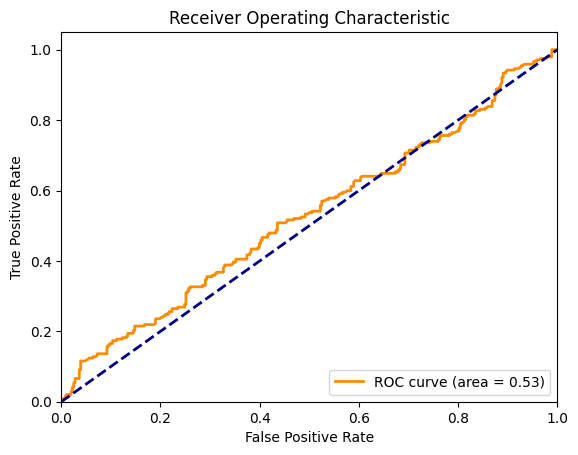

Feature importances for predicting true class: {'length_ratio': 1.0}
Feature importances for predicting model outputs: {'length_ratio': 1.0}
Dataset = XSUM
Trying pairwise
Accuracy for true class prediction: 0.4583333333333333
Accuracy for model output prediction: 0.62
AUC for true class prediction: 0.4723765500688919
AUC for model output prediction: 0.4951129503867195


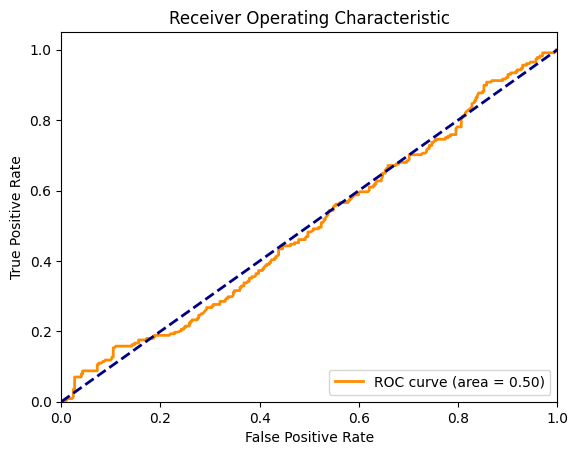

Feature importances for predicting true class: {'length_ratio': 1.0}
Feature importances for predicting model outputs: {'length_ratio': 1.0}
Dataset = DOLLY
Trying pairwise
Accuracy for true class prediction: 0.4740532959326788
Accuracy for model output prediction: 0.6690042075736325
AUC for true class prediction: 0.4951857975122028
AUC for model output prediction: 0.4852938563763636


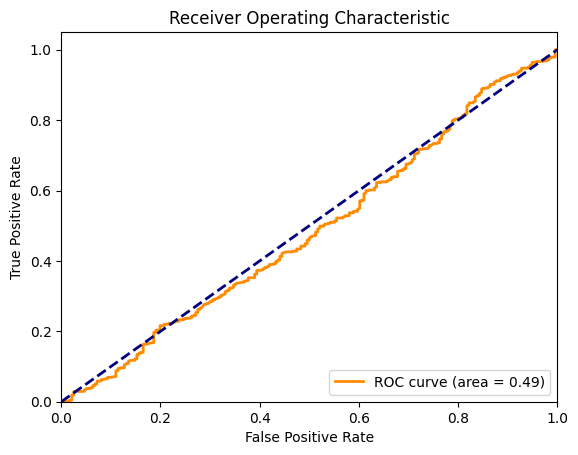

Feature importances for predicting true class: {'length_ratio': 1.0}
Feature importances for predicting model outputs: {'length_ratio': 1.0}


In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

def prepare_data(data, summaries, model_name, corvals=['1','2']):
    # Group data by model
    models = {}
    for item in data:
        model = item['model']
        if model not in models:
            models[model] = []
        models[model].append(item)

    all_data = []
    for model, items in models.items():
        if "human" not in model: continue
        self_lengths = [len(summaries[model_name][item['key']]) for item in items for i in range(2)]
        other_lengths = [len(summaries[model][item['key']]) for item in items for i in range(2)]
        length_ratios = [sl/ol for sl, ol in zip(self_lengths, other_lengths)]
        self_perplexities = [item['self_summary_perplexity'] for item in items for i in range(2)]
        other_perplexities = [item['other_summary_perplexity'] for item in items for i in range(2)]
        perplexity_ratios = [sp/op for sp, op in zip(self_perplexities, other_perplexities)]
        self_logprobs = [item['forward_detection_logprob'][corvals[0]] for item in items] + [item['backward_detection_logprob'][corvals[1]] for item in items]
        other_logprobs = [item['forward_detection_logprob'][corvals[1]] for item in items] + [item['backward_detection_logprob'][corvals[0]] for item in items]
        model_outputs = [item['forward_detection'] for item in items] + [item['backward_detection'] for item in items]
        reversed = [False for _ in items] + [True for _ in items]
        true_answers = ["1" for _ in items] + ["2" for _ in items]
    
        model_data = pd.DataFrame({
            'length_ratio': length_ratios,
            'perplexity_ratio': perplexity_ratios,
            'model_output': model_outputs,
            'true_class': true_answers,
            'is_reversed': reversed,
            'logprob_ratio': [sl/ol for sl, ol in zip(self_logprobs, other_logprobs)]
        })
        model_data['model_output'] = (model_data['model_output'] == "1").astype(int)
        model_data['true_class'] = (model_data['true_class'] == "1").astype(int)

        all_data.append(model_data)

    return pd.concat(all_data, ignore_index=True)

def analyze_model_outputs(data, feature_cols, output_col, true_class_col):
    X = data[feature_cols]
    y_true = data[true_class_col]  # true class labels
    y_model_outputs = data[output_col]  # model's predictions

    # Split data for evaluation
    X_train, X_test, y_train_true, y_test_true = train_test_split(X, y_true, test_size=0.3, random_state=42)
    _, _, y_train_model_outputs, y_test_model_outputs = train_test_split(X, y_model_outputs, test_size=0.3, random_state=42)

    # Model to predict true class labels
    model_true = LogisticRegression()
    model_true.fit(X_train, y_train_true)
    pred_true = model_true.predict_proba(X_test)[:, 1]

    # Model to predict original model outputs
    model_outputs = LogisticRegression()
    model_outputs.fit(X_train, y_train_model_outputs)
    pred_outputs = model_outputs.predict_proba(X_test)[:, 1]

    # Evaluate both models
    accuracy_true = accuracy_score(y_test_true, pred_true > 0.5)
    accuracy_outputs = accuracy_score(y_test_model_outputs, pred_outputs > 0.5)
    auc_true = roc_auc_score(y_test_true, pred_true)
    auc_outputs = roc_auc_score(y_test_model_outputs, pred_outputs)

    print(f"Accuracy for true class prediction: {accuracy_true}")
    print(f"Accuracy for model output prediction: {accuracy_outputs}")
    print(f"AUC for true class prediction: {auc_true}")
    print(f"AUC for model output prediction: {auc_outputs}")

    fpr, tpr, thresholds = roc_curve(y_test_model_outputs, pred_outputs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


    rf_true = RandomForestClassifier()
    rf_true.fit(X_train, y_train_true)
    importances_true = rf_true.feature_importances_

    # Random forest for predicting model outputs
    rf_outputs = RandomForestClassifier()
    rf_outputs.fit(X_train, y_train_model_outputs)
    importances_outputs = rf_outputs.feature_importances_

    print("Feature importances for predicting true class:", dict(zip(X.columns, importances_true)))
    print("Feature importances for predicting model outputs:", dict(zip(X.columns, importances_outputs)))


feature_cols = ['length_ratio']#, 'perplexity_ratio']#, 'is_reversed']
output_col = 'model_output'
true_class_col = 'true_class'

corvals=['1','2']
model_name = "llama3_8bchat"#"llama3_8bchat_filteredlen"#"llama3_8bchat"#
datasets = ["cnn","xsum","dolly"]
suffix = "_untuned"#"_filteredlen_untuned"#"_untuned"#
print(f"\t\tModel = {model_name}")
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    try:
        data = load_from_json(f'choice_results/{dataset}_{model_name.replace("_filteredlen","")}_SvO{suffix}.json')
    except:
        print("Trying pairwise")
        data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise{suffix}.json')
    
    responses, _, _ = load_data(dataset)
    data = prepare_data(data, responses, model_name, corvals=corvals)

    analyze_model_outputs(data, feature_cols, output_col, true_class_col)


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

def prepare_data(data, summaries, model_name, corvals=['1','2']):
    # Group data by model
    models = {}
    for item in data:
        model = item['model']
        if model not in models:
            models[model] = []
        models[model].append(item)

    all_data = []
    for model, items in models.items():
        self_lengths = [len(summaries[model_name][item['key']]) for item in items for i in range(2)]
        other_lengths = [len(summaries[model][item['key']]) for item in items for i in range(2)]
        length_ratios = [sl/ol for sl, ol in zip(self_lengths, other_lengths)]
        self_perplexities = [item['self_summary_perplexity'] for item in items for i in range(2)]
        other_perplexities = [item['other_summary_perplexity'] for item in items for i in range(2)]
        perplexity_ratios = [sp/op for sp, op in zip(self_perplexities, other_perplexities)]
        self_logprobs = [item['forward_detection_logprob'][corvals[0]] for item in items] + [item['backward_detection_logprob'][corvals[1]] for item in items]
        other_logprobs = [item['forward_detection_logprob'][corvals[1]] for item in items] + [item['backward_detection_logprob'][corvals[0]] for item in items]
        model_outputs = [1 if slp>olp else 0 for slp, olp in zip(self_logprobs, other_logprobs)]
        reversed = [False for _ in items] + [True for _ in items]
        true_answers = [1 for _ in items] + [0 for _ in items]
        correctness = [model_outputs[i] == true_answers[i] for i in range(len(model_outputs))]

        print(f"Mean correctness: {np.mean(correctness)}")
        print(f"Mean model_outputs: {np.mean(model_outputs)}")
        model_data = pd.DataFrame({
            'length_ratio': length_ratios,
            'perplexity_ratio': perplexity_ratios,
            'model_output': model_outputs,
            'correct_prediction': correctness,
        })

        all_data.append(model_data)

    return pd.concat(all_data, ignore_index=True)


# Function to perform logistic regression and print results
def analyze_predictiveness(subset, description):
    X = subset[['length_ratio', 'perplexity_ratio']]
    y = subset['model_output']
    
    model = LogisticRegression()
    model.fit(X, y)
    accuracy = accuracy_score(y, model.predict(X))
    
    print(f"Results for {description}:")
    print(f"  Coefficients: {model.coef_}")
    print(f"  Intercept: {model.intercept_}")
    print(f"  Accuracy: {accuracy}\n")

    logit_model = sm.Logit(y, sm.add_constant(X))
    result = logit_model.fit(disp=0)  # disp=0 disables fit information during the fitting process

    print(f"\nResults for {description}:")
    print("Coefficients and Confidence Intervals:")
    print(result.summary())
    print("Model Accuracy on the data:")
    print(f"Accuracy: {accuracy_score(y, result.predict(sm.add_constant(X)) > 0.5)}\n")

corvals=['1','2']
model_name = "llama3_8bchat"#"llama3_8bchat_filteredlen"#
datasets = ["cnn","xsum","dolly"]
suffix = "_untuned"#"_filteredlen_untuned"#
print(f"\t\tModel = {model_name}")
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    try:
        data = load_from_json(f'choice_results/{dataset}_{model_name.replace("_filteredlen","")}_SvO{suffix}.json')
    except:
        print("Trying pairwise")
        data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise{suffix}.json')
    
    responses, _, _ = load_data(dataset)
    data = prepare_data(data, responses, model_name, corvals=corvals)
    data['correct_prediction'] = data['correct_prediction'].astype(bool)
    data_correct = data[data['correct_prediction']]
    data_incorrect = data[~data['correct_prediction']]

    #With the intuition being that if the variable is similarly predictive in both then it is being used by the model, 
    # but if it is more predictive in correct trials then maybe it is just happens to be correlated with the true answer but isn't used by the model

    analyze_predictiveness(data_correct, "correct predictions")
    analyze_predictiveness(data_incorrect, "incorrect predictions")


		Model = llama3_8bchat
Dataset = CNN
Trying pairwise
Mean correctness: 0.4
Mean model_outputs: 0.871
Mean correctness: 0.363
Mean model_outputs: 0.721
Mean correctness: 0.3825
Mean model_outputs: 0.7635
Mean correctness: 0.386
Mean model_outputs: 0.563
Mean correctness: 0.397
Mean model_outputs: 0.668
Mean correctness: 0.379
Mean model_outputs: 0.67
Mean correctness: 0.357
Mean model_outputs: 0.701
Results for correct predictions:
  Coefficients: [[0.00933816 0.60593006]]
  Intercept: [0.60897954]
  Accuracy: 0.7735034715706511


Results for correct predictions:
Coefficients and Confidence Intervals:
                           Logit Regression Results                           
Dep. Variable:           model_output   No. Observations:                 5329
Model:                          Logit   Df Residuals:                     5327
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Jul 2024   Pseudo R-squ.:               0.0001

Dataset = SAD
Model = llama3_8bchat, Other Model = human, N = 1000


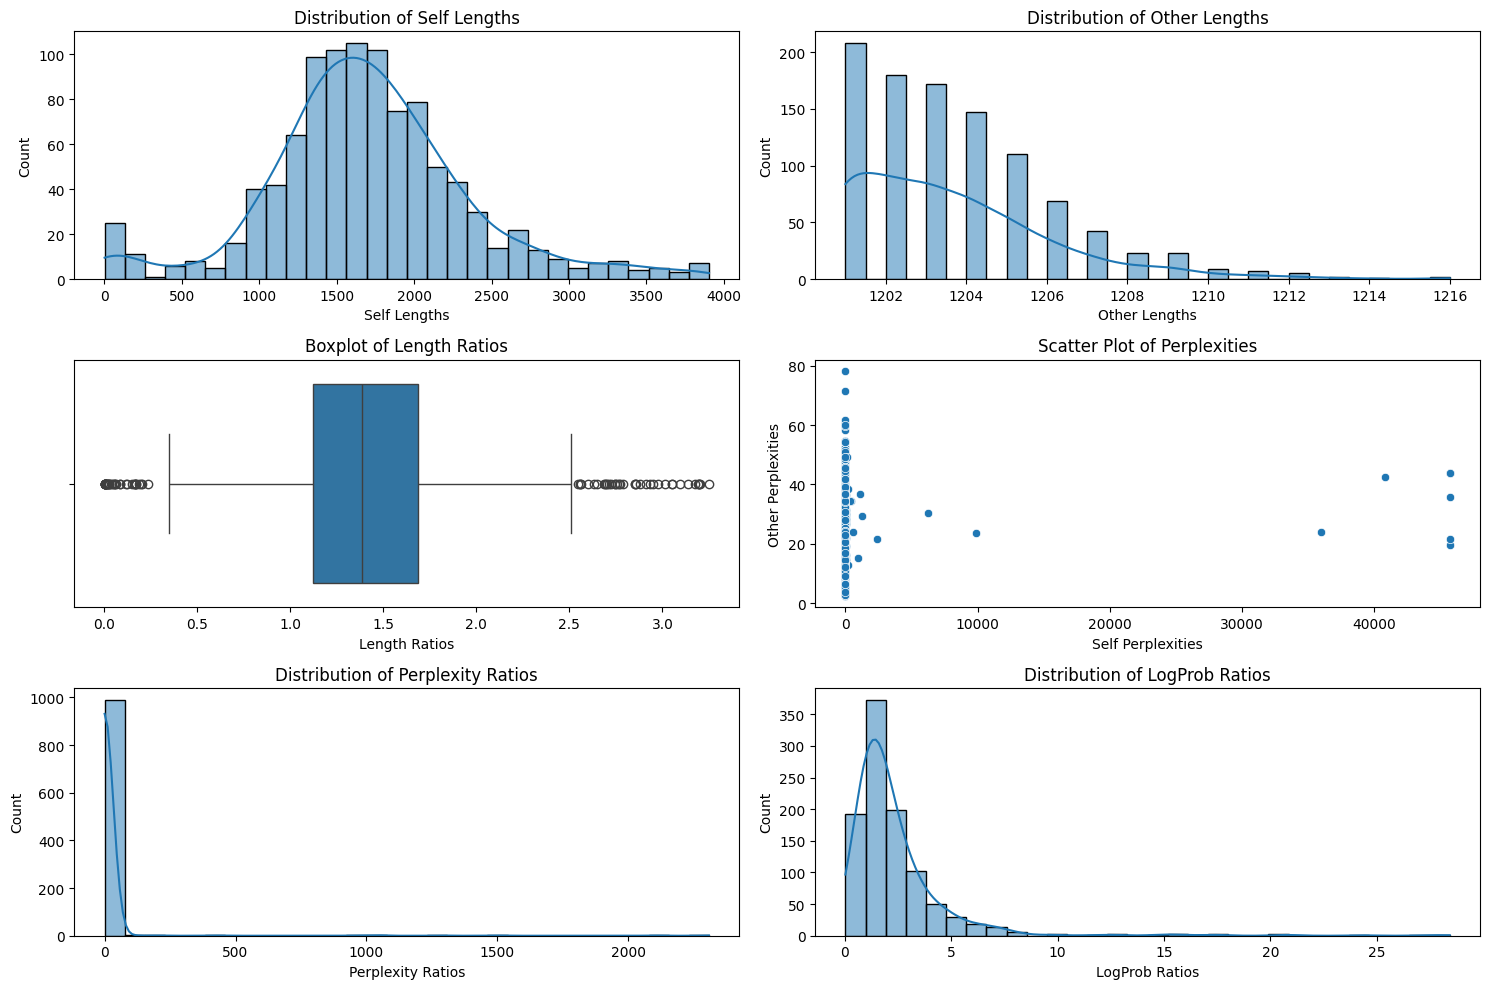

{'human':      Self Lengths  Other Lengths  Length Ratios  Self Perplexities  \
 0            1468           1207       1.216239           3.151745   
 1            1599           1205       1.326971           2.897011   
 2            1623           1203       1.349127           2.770975   
 3            1949           1203       1.620116           1.921489   
 4            1369           1201       1.139883           3.584633   
 ..            ...            ...            ...                ...   
 995          1371           1202       1.140599           2.963481   
 996          1819           1202       1.513311           2.449133   
 997          1750           1204       1.453488           2.059581   
 998          2096           1201       1.745212           2.183151   
 999          3739           1208       3.095199           1.565337   
 
      Other Perplexities  Perplexity Ratios  LogProb Ratios  
 0             52.647400           0.059865        3.199781  
 1           

In [79]:
## Visualize length/perplexity/logprob distributions

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_choice_data(data, summaries, model_name, comp_model, corvals=['1','2']):
    # Group data by model
    models = {}
    for item in data:
        model = item['model']
        if model not in models:
            models[model] = []
        models[model].append(item)

    results = {}
    for model, items in models.items():
        if comp_model not in model: continue
        self_lengths = [len(summaries[model_name][item['key']]) for item in items]
        other_lengths = [len(summaries[model][item['key']]) for item in items]
        length_ratios = [len(summaries[model_name][item['key']]) / len(summaries[model][item['key']]) for item in items]
        self_perplexities = [item['self_summary_perplexity'] for item in items]
        other_perplexities = [item['other_summary_perplexity'] for item in items]
        perplexity_ratios = [item['self_summary_perplexity'] / item['other_summary_perplexity'] for item in items]
        self_logprobs = [((item['forward_detection_logprob'][corvals[0]] + item['backward_detection_logprob'][corvals[1]]) / 2) for item in items]
        other_logprobs = [((item['forward_detection_logprob'][corvals[1]] + item['backward_detection_logprob'][corvals[0]]) / 2) for item in items]
        logprob_ratios = [self_logprobs[i] / other_logprobs[i] for i in range(len(self_logprobs))]

        # Create a DataFrame for easier plotting
        df = pd.DataFrame({
            'Self Lengths': self_lengths,
            'Other Lengths': other_lengths,
            'Length Ratios': length_ratios,
            'Self Perplexities': self_perplexities,
            'Other Perplexities': other_perplexities,
            'Perplexity Ratios': perplexity_ratios,
            'LogProb Ratios': logprob_ratios
        })

        # Plotting
        print(f"Model = {model_name}, Other Model = {model}, N = {len(df)}")
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
        sns.histplot(df['Self Lengths'], bins=30, kde=True, ax=axes[0, 0]).set_title('Distribution of Self Lengths')
        sns.histplot(df['Other Lengths'], bins=30, kde=True, ax=axes[0, 1]).set_title('Distribution of Other Lengths')
        sns.boxplot(x=df['Length Ratios'], ax=axes[1, 0]).set_title('Boxplot of Length Ratios')
        sns.scatterplot(x='Self Perplexities', y='Other Perplexities', data=df, ax=axes[1, 1]).set_title('Scatter Plot of Perplexities')
        sns.histplot(df['Perplexity Ratios'], bins=30, kde=True, ax=axes[2, 0]).set_title('Distribution of Perplexity Ratios')
        sns.histplot(df['LogProb Ratios'], bins=30, kde=True, ax=axes[2, 1]).set_title('Distribution of LogProb Ratios')

        plt.tight_layout()
        plt.show()

        results[model] = df

    return results

"""
corvals=['1','2']
model_name = "llama3_8bchat_filteredlen"
datasets = ["cnn","xsum","dolly"]
suffix = "_filteredlen_untuned"
print(f"\t\tModel = {model_name}")
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    try:
        data = load_from_json(f'choice_results/{dataset}_{model_name.replace("_filteredlen","")}_SvO{suffix}.json')
    except:
        print("Trying pairwise")
        data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise{suffix}.json')
    
    responses, _, _ = load_data(dataset)
    
    results = visualize_choice_data(data, responses, model_name, corvals=corvals)
"""
corvals=['1','2']
model_name = "llama3_8bchat"
type = "SvO"#"HvM"
suffix = "_longer"
dataset = "sad"
print(f"Dataset = {dataset.upper()}")
data = load_from_json(f'completions{suffix}/{dataset}_{model_name}_{type}_continuation{suffix}_untrimmed_untuned.json')
responses, _ = load_data_sad(f"completions{suffix}")
visualize_choice_data(data, responses, model_name, comp_model="human", corvals=corvals)


## Individual Presentation

In [ ]:
### inspect high confidence, correct, individual self and other judgement summaries

from collections import defaultdict
import random
model_name = "llama3_8bchat"

datasets = ["dolly","cnn"]

cnn_responses, cnn_articles, cnn_keys = load_data("cnn")
dolly_responses, dolly_articles, dolly_instructions, dolly_keys = load_data_dolly()

pairs = []
for dataset in datasets:
    responses = cnn_responses if dataset.startswith("cnn") else dolly_responses
    choices = load_from_json(f'choice_results/{dataset}_{model_name}_individual_untuned_nosuffix.json')

    models = set(item["model"] for item in choices)
    results = {model: defaultdict(dict) for model in models}

    # Organize data by key and model
    for item in choices:
        model = item["model"]
        key = item["key"]
        yes_logprob = item["individual_recognition_logprob"]["Yes"]
        no_logprob = item["individual_recognition_logprob"]["No"]

        results[model][key] = {
            "yes_logprob": yes_logprob,
            "no_logprob": no_logprob
        }

    strong_predictions = {}
    for key in results[model_name]:
        if results[model_name][key]["yes_logprob"] > 0.75:
            weak_models = [model for model in models if model != model_name and 
                            key in results[model] and 
                            results[model][key]["yes_logprob"] < 0.25]
            if weak_models:
                strong_predictions[key] = weak_models

    for key, weak_models in strong_predictions.items():
        random_weak_model = random.choice(weak_models)
        self_summary = responses[model_name][key]
        other_summary = responses[random_weak_model][key]
        pairs.append({"key": key, "self_summary": self_summary, "other_summary": other_summary})

print(pairs[0]['self_summary'])
print(pairs[0]['other_summary'])

In [5]:
### extract high confidence, correct, individual self and other judgement summaries

from collections import defaultdict
import pandas as pd
def extract_high_confidence_individual_judgements(choices, responses, dataset, model_name, comp_models = [], correct = True, abs_thresh = True):
    if comp_models == []: models = set(item["model"] for item in choices)
    else: models = comp_models + [model_name]
    results = {model: defaultdict(dict) for model in models}

    # Organize data by key and model
    for item in choices:
        model = item["model"]
        if model not in models: continue
        key = item["key"]
        yes_logprob = item["individual_recognition_logprob"]["Yes"]
        no_logprob = item["individual_recognition_logprob"]["No"]

        results[model][key] = {
            "yes_logprob": yes_logprob,
            "no_logprob": no_logprob
        }

    strong_predictions = {}
    for key in results[model_name]:
        if abs_thresh and dataset != "sad":
            thresh = 0#0.667 #0.75
            if (results[model_name][key]["yes_logprob"] > thresh if correct else results[model_name][key]["yes_logprob"] < (1-thresh)):
                weak_models = [model for model in models if model != model_name and 
                                key in results[model] and 
                                (results[model][key]["yes_logprob"] < (1-thresh) if correct else results[model][key]["yes_logprob"] > thresh)]
                if weak_models:
                    strong_predictions[key] = weak_models
        else:
            thresh = 1#0.2 #0.1
            weak_models = [model for model in models if model != model_name and 
                            key in results[model] and 
                            (results[model][key]["yes_logprob"]/results[model_name][key]["yes_logprob"] < thresh if correct else results[model_name][key]["yes_logprob"]/results[model][key]["yes_logprob"] < thresh)]
            if weak_models:
                strong_predictions[key] = weak_models

    print(f"Number of inputs where {model_name} made much " + ("stronger" if correct else "weaker") + f" predictions in {dataset}: {len(strong_predictions)}")

    import os, csv, random
    ofile = f"{model_name}_individual_" + ("strong" if correct else "wrong") + "_predictions_new3.csv"
    filterfile = f"{model_name}_individual_" + ("strong" if correct else "wrong") + "_predictions_new.csv"
    filter_df = pd.read_csv(filterfile)
    filterfile = f"{model_name}_individual_" + ("strong" if correct else "wrong") + "_predictions_new2.csv"
    filter_df2 = pd.read_csv(filterfile)
    file_exists = os.path.isfile(ofile)
    with open(ofile, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        if not file_exists:
            csvwriter.writerow(['dataset', 'input_id', 'weaker_model', 'self_output', 'other_output'])
        for key, weak_models in strong_predictions.items():
            if key in filter_df['input_id'].values or key in filter_df2['input_id'].values: continue
            random_weak_model = random.choice(weak_models)
            csvwriter.writerow([dataset, key, random_weak_model, responses[model_name][key], responses[random_weak_model][key]])

datasets = ["cnn", "xsum", "dolly", "sad"]
model_name = "llama3_8bchat"
for dataset in datasets:
    if dataset == "sad":
        choices = load_from_json(f'completions_full/sad_{model_name}_Ind_continuation_full_untuned.json')
        responses, _ = load_data_sad("completions_full")
    else:
        choices = load_from_json(f'choice_results/{dataset}_{model_name}_individual_untrimmed_untuned.json')
        if dataset == "dolly":
            responses, _, _, _ = load_data_dolly()
        else:    
            responses, _, _ = load_data(dataset)
    extract_high_confidence_individual_judgements(choices, responses, dataset, model_name, comp_models = ["human"], correct = True, abs_thresh = True)


Number of inputs where llama3_8bchat made much stronger predictions in cnn: 123
Number of inputs where llama3_8bchat made much stronger predictions in xsum: 298
Number of inputs where llama3_8bchat made much stronger predictions in dolly: 161
Number of inputs where llama3_8bchat made much stronger predictions in sad: 454


In [167]:
### Compute accuracy/f-score of model choices for individual task

from tabulate import tabulate
def avg(l):
    return sum(l) / len(l)
def print_pct_table(results, model_name):
    models = list({item['model']: None for item in results}.keys())
    table = [[model, 
              avg([result["individual_recognition"] == "Yes" for result in results if result['model']==model])
    ] for model in models]

    table = [row + [None if row[0] == model_name else table[0][1] / (table[0][1] + row[1]) if any(i != 0 for i in [table[0][1], row[1]]) else 0] for row in table]
    table = [row + [None if row[0] == model_name else 2 * (table[0][1] * row[2]) / (table[0][1] + row[2]) if any(i != 0 for i in [table[0][1], row[1]]) else 0] for row in table]

    table = [row[0:1] + [round(i, 3) for i in row[1:] if i is not None] for row in table]
    print(tabulate(table, headers = ['Model', '%Yes (Recall)', 'Precision', 'F-Score']))
    # print(tabulate(sorted())
"""
model_name = "llama3_8bchat"
print("\t\tModel = ", model_name)
print("Dataset = CNN")
results = load_from_json(f'choice_results/cnn_{model_name}_individual_untuned_nosuffix.json')#untuned_nosuffix.json')
print_pct_table(results, model_name)
print("\nDataset = DOLLY")
results = load_from_json(f'choice_results/dolly_{model_name}_individual_untuned_nosuffix.json')#_sprompt
print_pct_table(results, model_name)
"""
model_name = "llama3_8bchat"
print("\t\tModel = ", model_name)
print("Dataset = SAD")
results = load_from_json(f'completions_full/sad_{model_name}_Ind_continuation_full_untuned.json')
print_pct_table(results, model_name)

		Model =  llama3_8bchat
Dataset = SAD


ZeroDivisionError: float division by zero

In [ ]:
### Compute individual task confidence/details

from collections import defaultdict
from tabulate import tabulate
from statistics import median

def compare_models(data, base_model="llama3_8bchat"):
    models = set(item["model"] for item in data)
    results = {model: defaultdict(dict) for model in models}

    # Organize data by key and model
    for item in data:
        model = item["model"]
        key = item["key"]
        yes_logprob = item["individual_recognition_logprob"]["Yes"]
        perplexity = item["self_summary_perplexity"]
        is_yes = item["individual_recognition"] == "Yes"

        results[model][key] = {
            "yes_logprob": yes_logprob,
            "perplexity": perplexity,
            "is_yes": is_yes
        }

    table_data = []
    for model in models:
        if model == base_model:
            continue

        higher_logprob = sum(1 for key in results[base_model] if key in results[model] and results[model][key]["yes_logprob"] > results[base_model][key]["yes_logprob"])
        higher_perplexity = sum(1 for key in results[base_model] if key in results[model] and results[model][key]["perplexity"] > results[base_model][key]["perplexity"])
        higher_yes_perplexity = sum(1 for key in results[base_model] if key in results[model] and results[base_model][key]["is_yes"] and results[model][key]["perplexity"] > results[base_model][key]["perplexity"])

        total_count = len(results[base_model])
        yes_count = sum(1 for item in results[base_model].values() if item["is_yes"])

        avg_yes_logprob = sum(item["yes_logprob"] for item in results[model].values()) / len(results[model])
        avg_perplexity = sum(item["perplexity"] for item in results[model].values()) / len(results[model])
        avg_yes_perplexity = sum(item["perplexity"] for item in results[model].values() if item["is_yes"]) / sum(1 for item in results[model].values() if item["is_yes"])
        median_perplexity = median(item["perplexity"] for item in results[model].values())
        median_yes_perplexity = median(item["perplexity"] for item in results[model].values() if item["is_yes"])

        table_data.append([
            model,
            f"{higher_logprob / total_count:.2%}",
            f"{higher_perplexity / total_count:.2%}",
            f"{higher_yes_perplexity / yes_count:.2%}",
            f"{avg_yes_logprob:.4f}",
            f"{median_perplexity:.4f}",
            f"{median_yes_perplexity:.4f}"
        ])

    # Add base model data
    base_model_data = [
        base_model,
        "",
        "",
        "",
        f"{sum(item['yes_logprob'] for item in results[base_model].values()) / len(results[base_model]):.4f}",
#        f"{sum(item['perplexity'] for item in results[base_model].values()) / len(results[base_model]):.4f}",
#        f"{sum(item['perplexity'] for item in results[base_model].values() if item['is_yes']) / sum(1 for item in results[base_model].values() if item['is_yes']):.4f}"
        f"{median(item['perplexity'] for item in results[base_model].values()):.4f}",
        f"{median(item['perplexity'] for item in results[base_model].values() if item['is_yes']):.4f}"
    ]
    table_data.insert(0, base_model_data)

    headers = [
        "Model",
        "% Higher Yes LogProb",
        "% Higher Perplexity",
        "% Higher Yes Perplexity",
        "Avg Yes Prob",
        "Med Perplexity",
        "Med Yes Perplexity"
    ]

    print(tabulate(table_data, headers=headers))

datasets = ["dolly"]
model_name = "llama3_8bchat"
print("\t\tModel = ", model_name)
for dataset in datasets:
    print(f"Dataset = {dataset.upper()}")
    results = load_from_json(f'choice_results/{dataset}_{model_name}_individual_sprompt_untuned.json')
    compare_models(results, base_model=model_name)

In [189]:
# Judge individual responses by greatest yes/no ratio

from collections import defaultdict

def calculate_best_model_percentage(data, target_model, comp_models=None):
    # Group data by key (input)
    inputs = defaultdict(list)
    for entry in data:
        inputs[entry['key']].append(entry)
    
    total_inputs = len(inputs)
    print(f"Total inputs: {total_inputs}")
    target_model_wins = 0

    for input_data in inputs.values():
        best_ratio = 0
        best_model = None

        for entry in input_data:
            if comp_models and entry['model'] not in comp_models and entry['model'] != target_model: continue
            yes_prob = entry['individual_recognition_logprob']['Yes']
            no_prob = entry['individual_recognition_logprob']['No']
            
            ratio = yes_prob / max(no_prob,0.0000001)

            if ratio > best_ratio:
                best_ratio = ratio
                best_model = entry['model']

        if best_model == target_model:
            target_model_wins += 1

    percentage = (target_model_wins / total_inputs) * 100
    return percentage

model_name = "llama3_8bchat"
print("\t\tModel = ", model_name)
datasets = ["cnn","xsum","dolly", "sad"]
comp_models = ["llama3_8bchat"]
for dataset in datasets:
    print(f"\nDataset = {dataset.upper()}")
    if dataset == "sad":
        data = load_from_json(f'completions_full/sad_{model_name}_Ind_continuation_full_untuned.json')
    else:
        data = load_from_json(f'choice_results/{dataset}_{model_name}_individual_untrimmed_untuned.json')
    result = calculate_best_model_percentage(data, model_name, comp_models=comp_models)
    print(f"Comp models are {set([entry['model'] for entry in data if entry['model'] != model_name])}")
    print(f"The percentage of inputs where {model_name} has the highest Yes/No ratio: {result:.2f}%")
    print(f"Chance is {(1/len({entry['model'] for entry in data})):.2f}%")

		Model =  llama3_8bchat

Dataset = CNN
Total inputs: 1000
Comp models are {'gpt4', 'llama2_13bchat', 'claude', 'human', 'llama', 'llama3_8bbase', 'gpt35'}
The percentage of inputs where llama3_8bchat has the highest Yes/No ratio: 100.00%
Chance is 0.12%

Dataset = XSUM
Total inputs: 1000
Comp models are {'gpt4', 'llama2_13bchat', 'claude', 'human', 'llama', 'llama3_8bbase', 'gpt35'}
The percentage of inputs where llama3_8bchat has the highest Yes/No ratio: 100.00%
Chance is 0.12%

Dataset = DOLLY
Total inputs: 1188
Comp models are {'llama3_8bbase', 'human'}
The percentage of inputs where llama3_8bchat has the highest Yes/No ratio: 100.00%
Chance is 0.33%

Dataset = SAD
Total inputs: 1000
Comp models are {'human'}
The percentage of inputs where llama3_8bchat has the highest Yes/No ratio: 100.00%
Chance is 0.50%


In [190]:
import pandas as pd
from collections import defaultdict
from statsmodels.stats.proportion import proportion_confint, binom_test
from tabulate import tabulate

def calculate_best_model_percentage(data, target_model, comp_models=None):
    inputs = defaultdict(list)
    for entry in data:
        inputs[entry['key']].append(entry)
    
    model_comparisons = defaultdict(int)
    total_comparisons = defaultdict(int)
    yes_gt_no_counts = defaultdict(int)  # Track "Yes" > "No" instances

    for input_data in inputs.values():
        for entry in input_data:
            if comp_models and entry['model'] not in comp_models:
                continue

            yes_prob = entry['individual_recognition_logprob']['Yes']
            no_prob = entry['individual_recognition_logprob']['No']

            total_comparisons[entry['model']] += 1
            if yes_prob > no_prob:
                yes_gt_no_counts[entry['model']] += 1

            if entry['model'] != target_model:
                target_entry = next(e for e in input_data if e['model'] == target_model)
                target_ratio = target_entry['individual_recognition_logprob']['Yes'] / max(target_entry['individual_recognition_logprob']['No'], 1e-7)
                other_ratio = yes_prob / max(no_prob, 1e-7)
                if target_ratio > other_ratio:
                    model_comparisons[entry['model']] += 1

    results = []
    for model, wins in model_comparisons.items():
        total = total_comparisons[model]
        win_percentage = (wins / total) * 100
        lower, upper = proportion_confint(wins, total, method='wilson')
        p_value = binom_test(wins, total)
        yes_gt_no_percentage = (yes_gt_no_counts[model] / total) * 100
        results.append({
            "Model": model,
            "N": total,
            "Percentage Wins": f"{win_percentage:.2f}", 
            "Yes > No %": f"{yes_gt_no_percentage:.2f}",
            "Confidence Interval": f"{lower*100:.2f}% - {upper*100:.2f}%",
            "P-value": p_value
        })

    # Include target model results in the same format
    target_total = total_comparisons[target_model]
    target_wins = model_comparisons.get(target_model, 0)  # It should be zero because target doesn't compare with itself
    target_win_percentage = (target_wins / target_total) * 100 if target_total else 0
    target_yes_gt_no_percentage = (yes_gt_no_counts[target_model] / target_total) * 100 if target_total else 0
    results.append({
        "Model": target_model,
        "N": "",
        "Percentage Wins": "",
        "Yes > No %": f"{target_yes_gt_no_percentage:.2f}",
        "Confidence Interval": "",
        "P-value": "N/A"
    })

    results_df = pd.DataFrame(results)
    num_models = len(results_df)
#    numeric_df = results_df[results_df['P-value'] != "N/A"]
#    numeric_df['Corrected P-value'] = (numeric_df['P-value'] * num_models).clip(upper=1).apply(lambda x: f"{x:.4g}")
#    non_numeric_df = results_df[results_df['P-value'] == "N/A"]
#    non_numeric_df['Corrected P-value'] = ""
#    results_df = pd.concat([numeric_df, non_numeric_df])
    
    # Apply corrections directly with .loc to avoid SettingWithCopyWarning
    numeric_indices = results_df['P-value'].apply(lambda x: isinstance(x, (int, float)))
    results_df.loc[numeric_indices, 'Corrected P-value'] = (results_df.loc[numeric_indices, 'P-value'] * num_models).clip(upper=1).apply(lambda x: f"{x:.4g}")
    
    # Non-numeric (e.g., "N/A") P-values setting
    results_df.loc[~numeric_indices, 'Corrected P-value'] = ""
    
    # Sorting logic
    results_df['sort_key'] = results_df['Model'].apply(lambda x: (0 if x == target_model else (1 if x == 'human' else 2), x))
    results_df.sort_values('sort_key', inplace=True)
    results_df.drop(columns=['sort_key'], inplace=True)

    #def sort_key(x):
    #    return x.map(lambda val: (val != target_model, val.replace('human', 'aaa')))
    #results_df.sort_values(by='Model', inplace=True, key=sort_key)
    
    results_df = results_df[['Model', 'N', 'Yes > No %', 'Percentage Wins', 'Confidence Interval', 'Corrected P-value']]

    table = tabulate(results_df, headers='keys', showindex=False)
    return table


model_name = "llama3_8bchat"
print("\t\tModel = ", model_name)
datasets = ["cnn","xsum","dolly", "sad"]
for dataset in datasets:
    print(f"\nDataset = {dataset.upper()}")
    if dataset == "sad":
        data = load_from_json(f'completions_full/sad_{model_name}_Ind_continuation_full_untuned.json')
    else:
        data = load_from_json(f'choice_results/{dataset}_{model_name}_individual_untrimmed_untuned.json')
    result = calculate_best_model_percentage(data, model_name)
    print(result)


		Model =  llama3_8bchat

Dataset = CNN
Model           N       Yes > No %  Percentage Wins    Confidence Interval    Corrected P-value
--------------  ----  ------------  -----------------  ---------------------  -------------------
llama3_8bchat                 43.2
human           1000          22.1  72.60              69.75% - 75.27%        7.023e-47
claude          1000          38.5  59.00              55.92% - 62.01%        1.108e-07
gpt35           1000          31.4  66.00              63.01% - 68.87%        2.038e-23
gpt4            1000          43.7  50.70              47.60% - 53.79%        1
llama           1000          36.4  60.50              57.44% - 63.48%        2.631e-10
llama2_13bchat  1000          33.5  63.10              60.06% - 66.04%        8.267e-16
llama3_8bbase   1000          28.3  65.50              62.50% - 68.38%        5.421e-22

Dataset = XSUM
Model           N       Yes > No %  Percentage Wins    Confidence Interval    Corrected P-value
-----------